# Modeling

This notebook uses a wide variety of modeling algorithms for a binary classification problem. It reads a file created from a feature selection process that has a reasonably small number of good variables, and we know their order of multivariate importance because we used a proper wrapper method. We can explore # input variables, model algorithms and tune model hyperparameters. At the end we can select our favorite algorithm, run it again and build the final model performace score percentile tables.

There's also a cell that allows us to step through hyperparamters for any particular model to examine how the model overfits as a hyparameter changes.

Here we call the larger fraction population the goods and the smaller fraction the bads. This notebook was originally written for fraud detection but can be used for any binary classification. It uses detection rate as an appropriate measure of goodness.

Rather than use a built-in CV, we do a "manual CV" by running each model multiple (nitermax) times and average the performance on the training (trn), testing (tst) and out of time (oot) data sets.

Some of the ML algorithms are very fast and some are slow. Feel free to comment out any cells/models you want. At the bottom of the notebook you should select your final/best model and hyperparameters to run one time only and then make the business performance tables for that final model. Note once we've decided on the final model and hyperparameters we're allowed to make several trial runs of our final model train looking for a good performance on the testing data, as long as we don't make any changes to the model hyperparameters from our final choice.

Things to add: better calculation of FDR@3% when building a model using sampled training data. Right now I just approximate it by using the entire population trntst for a model built with sampled data.

In [1]:
from datetime import datetime
start_time = datetime.now()

import pandas as pd
import random
import xgboost as xgb
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from catboost import CatBoostClassifier
from sklearn.decomposition import PCA
import gc
import lightgbm as lgb
import numpy as np
import matplotlib.pyplot as plt 
%matplotlib inline

In [2]:
# This will let you see all the particular library vertsions you have loaded
# %pip list

In [3]:
%%time
vars = pd.read_csv('vars_final.csv')
print(vars.shape)
vars.head()

(98037, 22)
CPU times: user 372 ms, sys: 212 ms, total: 584 ms
Wall time: 866 ms


,Cardnum_unique_count_for_card_state_1,card_state_total_3,card_state_total_amount_1_by_60,Cardnum_max_14,card_zip_count_1_by_60,card_state_count_1_by_30_sq,Cardnum_count_0_by_60_sq,Card_dow_unique_count_for_state_des_30,Card_dow_unique_count_for_merch_state_14,Card_dow_unique_count_for_merch_zip_14,...,Card_dow_unique_count_for_merch_zip_30,card_zip_count_1_by_60_sq,Card_dow_unique_count_for_Card_Merchdesc_30,Cardnum_count_0_by_60,card_state_count_1_by_30,card_state_total_amount_1_by_30,card_zip_total_amount_1_by_30,Cardnum_unique_count_for_card_zip_7,Recnum,Fraud
0,1.0,3.62,0.016667,3.62,0.016667,0.001111,0.000278,1.0,1.0,1.0,...,1.0,0.000278,1.0,0.016667,0.033333,0.033333,0.033333,1.0,1,0.0
1,1.0,31.42,0.016667,31.42,0.016667,0.001111,0.000278,1.0,1.0,1.0,...,1.0,0.000278,1.0,0.016667,0.033333,0.033333,0.033333,1.0,2,0.0
2,1.0,178.49,0.016667,178.49,0.016667,0.001111,0.000278,1.0,1.0,1.0,...,1.0,0.000278,1.0,0.016667,0.033333,0.033333,0.033333,1.0,3,0.0
3,1.0,3.62,0.016667,3.62,0.016667,0.001111,0.000278,1.0,1.0,1.0,...,1.0,0.000278,1.0,0.016667,0.033333,0.033333,0.033333,1.0,4,0.0
4,1.0,7.24,0.016667,3.62,0.016667,0.001111,0.000278,1.0,1.0,1.0,...,1.0,0.000278,1.0,0.016667,0.033333,0.033333,0.033333,1.0,5,0.0


In [4]:
# set the number of variables desired here, and set the names of the y and record label properly
NVARS = 20

# vars.rename(columns={'record':'Recnum'},inplace=True)
# vars.rename(columns={'fraud_label':'Fraud'},inplace=True)
detect_rate = .03
numvars = min(NVARS,len(vars)-2)
final_vars_list = ['Recnum','Fraud']
for i in range(numvars):
    final_vars_list.append(vars.columns[i])
    
final_vars_list

['Recnum',
 'Fraud',
 'Cardnum_unique_count_for_card_state_1',
 'card_state_total_3',
 'card_state_total_amount_1_by_60',
 'Cardnum_max_14',
 'card_zip_count_1_by_60',
 'card_state_count_1_by_30_sq',
 'Cardnum_count_0_by_60_sq',
 'Card_dow_unique_count_for_state_des_30',
 'Card_dow_unique_count_for_merch_state_14',
 'Card_dow_unique_count_for_merch_zip_14',
 'Card_dow_total_60',
 'Card_dow_unique_count_for_merch_state_30',
 'Card_dow_unique_count_for_merch_zip_30',
 'card_zip_count_1_by_60_sq',
 'Card_dow_unique_count_for_Card_Merchdesc_30',
 'Cardnum_count_0_by_60',
 'card_state_count_1_by_30',
 'card_state_total_amount_1_by_30',
 'card_zip_total_amount_1_by_30',
 'Cardnum_unique_count_for_card_zip_7']

In [5]:
vars = vars.filter(final_vars_list,axis=1)
vars.head()

,Recnum,Fraud,Cardnum_unique_count_for_card_state_1,card_state_total_3,card_state_total_amount_1_by_60,Cardnum_max_14,card_zip_count_1_by_60,card_state_count_1_by_30_sq,Cardnum_count_0_by_60_sq,Card_dow_unique_count_for_state_des_30,...,Card_dow_total_60,Card_dow_unique_count_for_merch_state_30,Card_dow_unique_count_for_merch_zip_30,card_zip_count_1_by_60_sq,Card_dow_unique_count_for_Card_Merchdesc_30,Cardnum_count_0_by_60,card_state_count_1_by_30,card_state_total_amount_1_by_30,card_zip_total_amount_1_by_30,Cardnum_unique_count_for_card_zip_7
0,1,0.0,1.0,3.62,0.016667,3.62,0.016667,0.001111,0.000278,1.0,...,3.62,1.0,1.0,0.000278,1.0,0.016667,0.033333,0.033333,0.033333,1.0
1,2,0.0,1.0,31.42,0.016667,31.42,0.016667,0.001111,0.000278,1.0,...,31.42,1.0,1.0,0.000278,1.0,0.016667,0.033333,0.033333,0.033333,1.0
2,3,0.0,1.0,178.49,0.016667,178.49,0.016667,0.001111,0.000278,1.0,...,178.49,1.0,1.0,0.000278,1.0,0.016667,0.033333,0.033333,0.033333,1.0
3,4,0.0,1.0,3.62,0.016667,3.62,0.016667,0.001111,0.000278,1.0,...,3.62,1.0,1.0,0.000278,1.0,0.016667,0.033333,0.033333,0.033333,1.0
4,5,0.0,1.0,7.24,0.016667,3.62,0.016667,0.001111,0.000278,1.0,...,7.24,1.0,1.0,0.000278,1.0,0.016667,0.033333,0.033333,0.033333,1.0


In [6]:
vars.shape

(98037, 22)

In [7]:
vars['Fraud'].sum()

2492.0

In [8]:
print("fraud rate in data is",(vars['Fraud'].sum()/len(vars)).round(4))

fraud rate in data is 0.0254


In [9]:
vars.head(10)

,Recnum,Fraud,Cardnum_unique_count_for_card_state_1,card_state_total_3,card_state_total_amount_1_by_60,Cardnum_max_14,card_zip_count_1_by_60,card_state_count_1_by_30_sq,Cardnum_count_0_by_60_sq,Card_dow_unique_count_for_state_des_30,...,Card_dow_total_60,Card_dow_unique_count_for_merch_state_30,Card_dow_unique_count_for_merch_zip_30,card_zip_count_1_by_60_sq,Card_dow_unique_count_for_Card_Merchdesc_30,Cardnum_count_0_by_60,card_state_count_1_by_30,card_state_total_amount_1_by_30,card_zip_total_amount_1_by_30,Cardnum_unique_count_for_card_zip_7
0,1,0.0,1.0,3.62,0.016667,3.62,0.016667,0.001111,0.000278,1.0,...,3.62,1.0,1.0,0.000278,1.0,0.016667,0.033333,0.033333,0.033333,1.0
1,2,0.0,1.0,31.42,0.016667,31.42,0.016667,0.001111,0.000278,1.0,...,31.42,1.0,1.0,0.000278,1.0,0.016667,0.033333,0.033333,0.033333,1.0
2,3,0.0,1.0,178.49,0.016667,178.49,0.016667,0.001111,0.000278,1.0,...,178.49,1.0,1.0,0.000278,1.0,0.016667,0.033333,0.033333,0.033333,1.0
3,4,0.0,1.0,3.62,0.016667,3.62,0.016667,0.001111,0.000278,1.0,...,3.62,1.0,1.0,0.000278,1.0,0.016667,0.033333,0.033333,0.033333,1.0
4,5,0.0,1.0,7.24,0.016667,3.62,0.016667,0.001111,0.000278,1.0,...,7.24,1.0,1.0,0.000278,1.0,0.016667,0.033333,0.033333,0.033333,1.0
5,6,0.0,1.0,3.67,0.016667,3.67,0.016667,0.001111,0.000278,1.0,...,3.67,1.0,1.0,0.000278,1.0,0.016667,0.033333,0.033333,0.033333,1.0
6,7,0.0,1.0,3.62,0.016667,3.62,0.016667,0.001111,0.000278,1.0,...,3.62,1.0,1.0,0.000278,1.0,0.016667,0.033333,0.033333,0.033333,1.0
7,8,0.0,1.0,230.32,0.016667,230.32,0.016667,0.001111,0.000278,1.0,...,230.32,1.0,1.0,0.000278,1.0,0.016667,0.033333,0.033333,0.033333,1.0
8,9,0.0,1.0,62.11,0.016667,62.11,0.016667,0.001111,0.000278,1.0,...,62.11,1.0,1.0,0.000278,1.0,0.016667,0.033333,0.033333,0.033333,1.0
9,10,0.0,1.0,10.86,0.016667,3.62,0.016667,0.001111,0.000278,1.0,...,10.86,1.0,1.0,0.000278,1.0,0.016667,0.033333,0.033333,0.033333,1.0


In [10]:
vars.shape

(98037, 22)

In [11]:
vars.describe()

,Recnum,Fraud,Cardnum_unique_count_for_card_state_1,card_state_total_3,card_state_total_amount_1_by_60,Cardnum_max_14,card_zip_count_1_by_60,card_state_count_1_by_30_sq,Cardnum_count_0_by_60_sq,Card_dow_unique_count_for_state_des_30,...,Card_dow_total_60,Card_dow_unique_count_for_merch_state_30,Card_dow_unique_count_for_merch_zip_30,card_zip_count_1_by_60_sq,Card_dow_unique_count_for_Card_Merchdesc_30,Cardnum_count_0_by_60,card_state_count_1_by_30,card_state_total_amount_1_by_30,card_zip_total_amount_1_by_30,Cardnum_unique_count_for_card_zip_7
count,98037.000000,98037.000000,98037.000000,98037.000000,9.803700e+04,98037.000000,98037.000000,98037.000000,9.803700e+04,98037.000000,...,98037.000000,98037.000000,98037.000000,9.803700e+04,98037.000000,98037.000000,98037.000000,98037.000000,98037.000000,98037.000000
mean,49185.587992,0.025419,1.757020,733.620037,8.024469e-03,1194.259716,0.011052,0.000654,4.180968e-05,3.449922,...,2556.377100,3.066995,3.069606,1.841988e-04,3.449647,0.002509,0.019615,0.019363,0.024224,3.847323
std,28418.418181,0.157395,1.643117,4087.096369,6.649885e-03,1852.307476,0.006105,0.000398,5.671510e-05,3.377390,...,6124.742345,3.032240,3.033772,1.017428e-04,3.377386,0.003403,0.011948,0.013155,0.012273,3.937186
min,1.000000,0.000000,1.000000,0.010000,1.901394e-07,0.140000,0.000030,0.000003,5.050505e-07,1.000000,...,0.170000,1.000000,1.000000,5.078204e-07,1.000000,0.000030,0.000079,0.000001,0.000001,1.000000
25%,24564.000000,0.000000,1.000000,65.540000,1.552354e-03,309.020000,0.005556,0.000278,1.068376e-05,1.000000,...,301.680000,1.000000,1.000000,9.259259e-05,1.000000,0.000641,0.008333,0.005674,0.012366,2.000000
50%,49186.000000,0.000000,1.000000,217.760000,5.961863e-03,804.930000,0.016667,0.000556,2.136752e-05,2.000000,...,1081.910000,2.000000,2.000000,2.777778e-04,2.000000,0.001282,0.016667,0.019737,0.033333,3.000000
75%,73808.000000,0.000000,2.000000,658.000000,1.666667e-02,1741.460000,0.016667,0.001111,4.629630e-05,4.000000,...,2856.670000,4.000000,4.000000,2.777778e-04,4.000000,0.002778,0.033333,0.033333,0.033333,5.000000
max,98393.000000,1.000000,21.000000,306633.410000,1.666667e-02,47900.000000,0.016667,0.001111,2.777778e-04,50.000000,...,222678.830000,48.000000,48.000000,2.777778e-04,50.000000,0.016667,0.033333,0.033333,0.033333,50.000000


In [12]:
# find the row i vars that corresponds to 11/1 for the OOT
test = vars[vars['Recnum'] > 85725]
test.head(10)

,Recnum,Fraud,Cardnum_unique_count_for_card_state_1,card_state_total_3,card_state_total_amount_1_by_60,Cardnum_max_14,card_zip_count_1_by_60,card_state_count_1_by_30_sq,Cardnum_count_0_by_60_sq,Card_dow_unique_count_for_state_des_30,...,Card_dow_total_60,Card_dow_unique_count_for_merch_state_30,Card_dow_unique_count_for_merch_zip_30,card_zip_count_1_by_60_sq,Card_dow_unique_count_for_Card_Merchdesc_30,Cardnum_count_0_by_60,card_state_count_1_by_30,card_state_total_amount_1_by_30,card_zip_total_amount_1_by_30,Cardnum_unique_count_for_card_zip_7
85396,85726,0.0,1.0,789.32,0.016667,609.34,0.016667,0.001111,0.000278,1.0,...,789.32,1.0,1.0,0.000278,1.0,0.016667,0.033333,0.033333,0.033333,1.0
85397,85727,0.0,1.0,235.00,0.016667,399.15,0.016667,0.001111,0.000046,1.0,...,235.00,1.0,1.0,0.000278,1.0,0.002778,0.033333,0.033333,0.033333,2.0
85398,85728,0.0,1.0,600.00,0.016667,600.00,0.016667,0.001111,0.000278,1.0,...,600.00,1.0,1.0,0.000278,1.0,0.016667,0.033333,0.033333,0.033333,1.0
85399,85729,0.0,1.0,30.00,0.001265,30.00,0.008333,0.000556,0.000031,1.0,...,40.86,1.0,1.0,0.000139,1.0,0.001852,0.016667,0.002530,0.002530,1.0
85400,85730,0.0,1.0,182.00,0.004183,1573.30,0.016667,0.000556,0.000008,3.0,...,586.24,3.0,3.0,0.000278,3.0,0.000505,0.016667,0.008366,0.033333,8.0
85401,85731,0.0,1.0,174.61,0.007283,225.00,0.008333,0.000556,0.000139,1.0,...,174.61,1.0,1.0,0.000139,1.0,0.008333,0.016667,0.014565,0.014565,1.0
85402,85732,0.0,1.0,259.90,0.000311,395.00,0.001515,0.000159,0.000010,2.0,...,609.35,3.0,3.0,0.000025,2.0,0.000575,0.004762,0.001800,0.003219,3.0
85403,85733,0.0,1.0,25.00,0.000346,531.25,0.005556,0.000222,0.000019,3.0,...,525.90,3.0,3.0,0.000093,3.0,0.001111,0.006667,0.001398,0.015582,2.0
85404,85734,0.0,1.0,97.17,0.000987,395.04,0.016667,0.000556,0.000019,1.0,...,375.17,1.0,1.0,0.000278,1.0,0.001111,0.016667,0.010614,0.033333,1.0
85405,85735,0.0,1.0,6.51,0.003082,6.51,0.005556,0.000556,0.000093,1.0,...,32.71,1.0,1.0,0.000093,1.0,0.005556,0.016667,0.024111,0.024111,1.0


In [13]:
record_save = vars['Recnum']
Y_save = pd.DataFrame(vars.loc[:,'Fraud'])
Y_save.head()

,Fraud
0,0.0
1,0.0
2,0.0
3,0.0
4,0.0


## Scale and truncate field values

In [14]:
X_no_scaling = vars.drop(columns = ['Recnum','Fraud'])
X_no_scaling.describe()

,Cardnum_unique_count_for_card_state_1,card_state_total_3,card_state_total_amount_1_by_60,Cardnum_max_14,card_zip_count_1_by_60,card_state_count_1_by_30_sq,Cardnum_count_0_by_60_sq,Card_dow_unique_count_for_state_des_30,Card_dow_unique_count_for_merch_state_14,Card_dow_unique_count_for_merch_zip_14,Card_dow_total_60,Card_dow_unique_count_for_merch_state_30,Card_dow_unique_count_for_merch_zip_30,card_zip_count_1_by_60_sq,Card_dow_unique_count_for_Card_Merchdesc_30,Cardnum_count_0_by_60,card_state_count_1_by_30,card_state_total_amount_1_by_30,card_zip_total_amount_1_by_30,Cardnum_unique_count_for_card_zip_7
count,98037.000000,98037.000000,9.803700e+04,98037.000000,98037.000000,98037.000000,9.803700e+04,98037.000000,98037.000000,98037.000000,98037.000000,98037.000000,98037.000000,9.803700e+04,98037.000000,98037.000000,98037.000000,98037.000000,98037.000000,98037.000000
mean,1.757020,733.620037,8.024469e-03,1194.259716,0.011052,0.000654,4.180968e-05,3.449922,2.333221,2.335006,2556.377100,3.066995,3.069606,1.841988e-04,3.449647,0.002509,0.019615,0.019363,0.024224,3.847323
std,1.643117,4087.096369,6.649885e-03,1852.307476,0.006105,0.000398,5.671510e-05,3.377390,2.316602,2.317518,6124.742345,3.032240,3.033772,1.017428e-04,3.377386,0.003403,0.011948,0.013155,0.012273,3.937186
min,1.000000,0.010000,1.901394e-07,0.140000,0.000030,0.000003,5.050505e-07,1.000000,1.000000,1.000000,0.170000,1.000000,1.000000,5.078204e-07,1.000000,0.000030,0.000079,0.000001,0.000001,1.000000
25%,1.000000,65.540000,1.552354e-03,309.020000,0.005556,0.000278,1.068376e-05,1.000000,1.000000,1.000000,301.680000,1.000000,1.000000,9.259259e-05,1.000000,0.000641,0.008333,0.005674,0.012366,2.000000
50%,1.000000,217.760000,5.961863e-03,804.930000,0.016667,0.000556,2.136752e-05,2.000000,2.000000,2.000000,1081.910000,2.000000,2.000000,2.777778e-04,2.000000,0.001282,0.016667,0.019737,0.033333,3.000000
75%,2.000000,658.000000,1.666667e-02,1741.460000,0.016667,0.001111,4.629630e-05,4.000000,3.000000,3.000000,2856.670000,4.000000,4.000000,2.777778e-04,4.000000,0.002778,0.033333,0.033333,0.033333,5.000000
max,21.000000,306633.410000,1.666667e-02,47900.000000,0.016667,0.001111,2.777778e-04,50.000000,41.000000,41.000000,222678.830000,48.000000,48.000000,2.777778e-04,50.000000,0.016667,0.033333,0.033333,0.033333,50.000000


In [15]:
X = (X_no_scaling - X_no_scaling.mean()) / X_no_scaling.std()

In [16]:
# Outlier treatment: use this to limit variables. For some problems it helps
Clip = 10

In [17]:
# push in any outlier values, then rescale
X.clip(-1*Clip,Clip,inplace=True)
X = (X - X.mean()) / X.std()
X.describe()

,Cardnum_unique_count_for_card_state_1,card_state_total_3,card_state_total_amount_1_by_60,Cardnum_max_14,card_zip_count_1_by_60,card_state_count_1_by_30_sq,Cardnum_count_0_by_60_sq,Card_dow_unique_count_for_state_des_30,Card_dow_unique_count_for_merch_state_14,Card_dow_unique_count_for_merch_zip_14,Card_dow_total_60,Card_dow_unique_count_for_merch_state_30,Card_dow_unique_count_for_merch_zip_30,card_zip_count_1_by_60_sq,Card_dow_unique_count_for_Card_Merchdesc_30,Cardnum_count_0_by_60,card_state_count_1_by_30,card_state_total_amount_1_by_30,card_zip_total_amount_1_by_30,Cardnum_unique_count_for_card_zip_7
count,9.803700e+04,9.803700e+04,9.803700e+04,9.803700e+04,9.803700e+04,9.803700e+04,9.803700e+04,9.803700e+04,9.803700e+04,9.803700e+04,9.803700e+04,9.803700e+04,9.803700e+04,9.803700e+04,9.803700e+04,9.803700e+04,9.803700e+04,9.803700e+04,9.803700e+04,9.803700e+04
mean,-5.740178e-17,7.827516e-18,4.406601e-17,-2.609172e-18,-2.783117e-17,9.277056e-18,8.697240e-19,1.971374e-17,2.551190e-17,-2.899080e-18,5.073390e-18,-1.000183e-17,-3.188988e-17,-1.623485e-17,1.159632e-18,-1.826420e-17,-2.551190e-17,3.131006e-17,8.813203e-17,-4.638528e-18
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-4.624561e-01,-3.535511e-01,-1.206679e+00,-7.218116e-01,-1.805445e+00,-1.635089e+00,-7.282828e-01,-7.301471e-01,-5.910956e-01,-5.916135e-01,-4.967949e-01,-6.903539e-01,-6.908462e-01,-1.805445e+00,-7.300661e-01,-7.282828e-01,-1.635089e+00,-1.471834e+00,-1.973594e+00,-7.248729e-01
25%,-4.624561e-01,-3.196503e-01,-9.732673e-01,-5.323110e-01,-9.003706e-01,-9.442087e-01,-5.488119e-01,-7.301471e-01,-5.910956e-01,-5.916135e-01,-4.366423e-01,-6.903539e-01,-6.908462e-01,-9.003706e-01,-7.300661e-01,-5.488119e-01,-9.442087e-01,-1.040568e+00,-9.661747e-01,-4.702020e-01
50%,-4.624561e-01,-2.409018e-01,-3.101716e-01,-2.280658e-01,9.197603e-01,-2.467484e-01,-3.604359e-01,-4.318418e-01,-1.457875e-01,-1.465178e-01,-2.809830e-01,-3.557482e-01,-3.564269e-01,9.197603e-01,-4.317603e-01,-3.604359e-01,-2.467484e-01,2.846589e-02,7.422132e-01,-2.155310e-01
75%,1.490252e-01,-1.315083e-02,1.299601e+00,3.465037e-01,9.197603e-01,1.148172e+00,7.910798e-02,1.647688e-01,2.995206e-01,2.985779e-01,7.308935e-02,3.134632e-01,3.124119e-01,9.197603e-01,1.648513e-01,7.910798e-02,1.148172e+00,1.061983e+00,7.422132e-01,2.938109e-01
max,1.004780e+01,2.116989e+01,1.299601e+00,1.137486e+01,9.197603e-01,1.148172e+00,4.160587e+00,1.007561e+01,1.031861e+01,1.031776e+01,1.223231e+01,1.014732e+01,1.014679e+01,9.197603e-01,1.007562e+01,4.160587e+00,1.148172e+00,1.061983e+00,7.422132e-01,1.002713e+01


In [18]:
# separate data into modeling (traintest) and out of time. Here I'm using the record number to do this separation.
# you need to change this OOT record number to whatever is appropriate for your data
oot_recnum = 85400
X_trntst = X[0:oot_recnum]
Y_trntst = Y_save[0:oot_recnum]
X_oot = X[oot_recnum:]
Y_oot = Y_save[oot_recnum:]
Y_oot.sum()

Fraud    356.0
dtype: float64

## Look at PCA

In [19]:
len(X_trntst.columns)

20

In [20]:
X_trntst_save = X_trntst.copy()

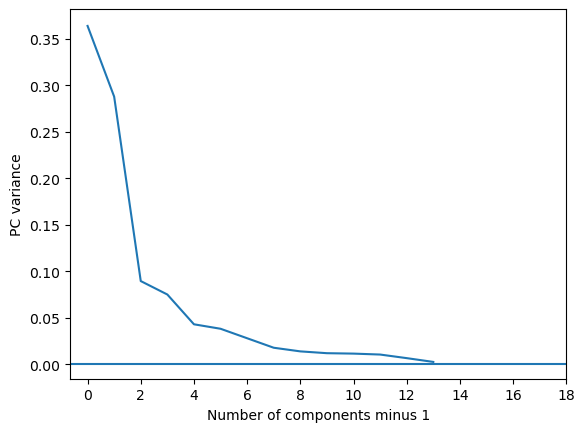

In [21]:
pca = PCA(n_components = .999, svd_solver = 'full')
pca.fit(X_trntst)
plt.plot(pca.explained_variance_ratio_)
plt.xlabel('Number of components minus 1')
plt.ylabel('PC variance')
plt.xticks(np.arange(0, len(X_trntst.columns), step=2))
plt.axhline(y=0,xmin=0,xmax=len(X_trntst.columns))
X_trntst = X_trntst_save.copy()

In [22]:
# We look at the above picture, select how many PCs we want to keep, and then redo the PCA with just this many PCs
pca = PCA(n_components = 4, svd_solver = 'full')
princ_comps = pca.fit_transform(X_trntst)
X_trntst_pca = pd.DataFrame(princ_comps, columns = ['PC' + str(i) for i in range(1, pca.n_components_+1)])
X_trntst_pca.head()

,PC1,PC2,PC3,PC4
0,-4.064014,2.977774,-3.171235,3.264320
1,-4.060090,2.980416,-3.154628,3.277420
2,-4.039331,2.994388,-3.066772,3.346722
3,-4.064014,2.977774,-3.171235,3.264320
4,-4.063792,2.977966,-3.170128,3.265362


In [23]:
princ_comps = pca.transform(X_oot)
X_oot_orig_pca = pd.DataFrame(princ_comps, columns = ['PC' + str(i) for i in range(1, pca.n_components_+1)],index=X_oot.index)
X_oot_orig_pca.head()

,PC1,PC2,PC3,PC4
85400,0.051813,-0.006585,0.697617,-1.106422
85401,-1.912461,-1.081836,-1.696234,1.803600
85402,1.128827,-3.553770,-0.540764,0.093432
85403,0.877184,-2.621228,-0.526890,-0.132879
85404,-1.643450,-0.825419,0.462032,-0.953802


In [24]:
X_trntst.describe()

,Cardnum_unique_count_for_card_state_1,card_state_total_3,card_state_total_amount_1_by_60,Cardnum_max_14,card_zip_count_1_by_60,card_state_count_1_by_30_sq,Cardnum_count_0_by_60_sq,Card_dow_unique_count_for_state_des_30,Card_dow_unique_count_for_merch_state_14,Card_dow_unique_count_for_merch_zip_14,Card_dow_total_60,Card_dow_unique_count_for_merch_state_30,Card_dow_unique_count_for_merch_zip_30,card_zip_count_1_by_60_sq,Card_dow_unique_count_for_Card_Merchdesc_30,Cardnum_count_0_by_60,card_state_count_1_by_30,card_state_total_amount_1_by_30,card_zip_total_amount_1_by_30,Cardnum_unique_count_for_card_zip_7
count,85400.000000,85400.000000,85400.000000,85400.000000,85400.000000,85400.000000,85400.000000,85400.000000,85400.000000,85400.000000,85400.000000,85400.000000,85400.000000,85400.000000,85400.000000,85400.000000,85400.000000,85400.000000,85400.000000,85400.000000
mean,0.005402,0.001902,-0.007191,0.003646,-0.016853,-0.016394,0.000793,0.018604,0.004191,0.004150,-0.000762,0.005577,0.005516,-0.016853,0.018592,0.000793,-0.016394,-0.014047,-0.016926,0.006940
std,1.010079,1.015093,1.000565,0.986430,1.008559,1.003052,1.015169,1.025655,1.015940,1.015793,0.992372,1.017645,1.017414,1.008559,1.025657,1.015169,1.003052,1.001800,1.008416,1.009096
min,-0.462456,-0.353551,-1.206679,-0.721812,-1.805445,-1.635089,-0.728283,-0.730147,-0.591096,-0.591614,-0.496795,-0.690354,-0.690846,-1.805445,-0.730066,-0.728283,-1.635089,-1.471834,-1.973594,-0.724873
25%,-0.462456,-0.319930,-0.978909,-0.528642,-0.900371,-0.944209,-0.555789,-0.730147,-0.591096,-0.591614,-0.437307,-0.690354,-0.690846,-0.900371,-0.730066,-0.555789,-0.944209,-1.053055,-1.017222,-0.470202
50%,-0.462456,-0.241329,-0.325085,-0.219636,0.822253,-0.246748,-0.360436,-0.431842,-0.145788,-0.146518,-0.283326,-0.355748,-0.356427,0.822253,-0.431760,-0.360436,-0.246748,-0.021925,0.742213,-0.215531
75%,0.149025,-0.013151,1.299601,0.354197,0.919760,1.148172,0.079108,0.164769,0.299521,0.298578,0.073238,0.313463,0.312412,0.919760,0.164851,0.079108,1.148172,1.061983,0.742213,0.293811
max,10.047803,21.169890,1.299601,11.374863,0.919760,1.148172,4.160587,10.075611,10.318614,10.317765,12.232308,10.147323,10.146791,0.919760,10.075616,4.160587,1.148172,1.061983,0.742213,10.027127


In [25]:
X_oot_orig_pca.describe()

,PC1,PC2,PC3,PC4
count,12637.000000,12637.000000,12637.000000,12637.000000
mean,-0.286376,0.192274,0.094657,-0.094231
std,2.448981,2.168813,1.247198,1.174405
min,-4.064278,-4.723788,-6.137433,-2.403509
25%,-1.942138,-1.516203,-0.422232,-0.857182
50%,-0.654538,0.317611,0.090706,-0.266898
75%,0.716988,1.834312,0.555236,0.306240
max,21.795096,14.008552,20.376231,15.253709


In [26]:
# zscale the PCs
mean = X_trntst_pca.mean()
stdev = X_trntst_pca.std()
X_trntst_pca = (X_trntst_pca - mean)/stdev
X_oot_orig_pca = (X_oot_orig_pca - mean)/stdev

In [27]:
X_trntst_pca.describe()

,PC1,PC2,PC3,PC4
count,8.540000e+04,8.540000e+04,8.540000e+04,8.540000e+04
mean,1.597473e-17,-2.928701e-17,-6.656138e-18,1.064982e-17
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-1.492201e+00,-1.989802e+00,-6.365803e+00,-2.456144e+00
25%,-6.388938e-01,-8.094097e-01,-3.938922e-01,-6.285542e-01
50%,-1.378569e-01,1.901660e-02,3.571317e-02,-1.059823e-01
75%,4.013353e-01,7.647671e-01,4.155998e-01,2.909018e-01
max,1.046647e+01,6.716148e+00,1.445030e+01,1.471977e+01


In [28]:
X_oot_orig_pca.describe()

,PC1,PC2,PC3,PC4
count,12637.000000,12637.000000,12637.000000,12637.000000
mean,-0.105137,0.079369,0.070071,-0.076179
std,0.899095,0.895268,0.923258,0.949418
min,-1.492119,-1.949941,-4.543331,-1.943056
25%,-0.713018,-0.625876,-0.312564,-0.692967
50%,-0.240301,0.131107,0.067146,-0.215767
75%,0.263228,0.757189,0.411022,0.247572
max,8.001640,5.782615,15.083824,12.331476


In [29]:
X_trntst_pca.shape

(85400, 4)

In [30]:
X_oot_orig_pca.shape

(12637, 4)

## Subsample the larger class if desired

In [31]:
# set the ratio of goods to bads that you would like. This next line is the ratio of goods to bads that you want for modeling
sample_ratio_desired = 1

temp = X_trntst.copy()
temp['Fraud'] = Y_trntst['Fraud']
temp.head()
goods = temp[temp['Fraud']==0]
bads = temp[temp['Fraud']==1]
actual_bad_fraction = len(bads)/len(temp)
actual_good_fraction = 1 - actual_bad_fraction
print(actual_bad_fraction)
fraction = sample_ratio_desired * actual_bad_fraction
goods_sampled = goods.sample(frac = fraction)
all_sampled = pd.concat([goods_sampled,bads])
all_sampled.sort_index(inplace=True)
Y_trntst_sampled = pd.DataFrame(all_sampled['Fraud'])
X_trntst_sampled = all_sampled.drop(columns=['Fraud'])
del [temp,goods,bads,all_sampled]
gc.collect()
print(X_trntst_sampled.shape,len(Y_trntst_sampled))

0.025011709601873537
(4219, 20) 4219


In [32]:
# We do a manual cross validation by running each model nitermax times for each choice of hyperparameters. The good
# statistical measurement of the model performance is the average across all these nitermax runs.
niter = 0
nitermax = 10
jittersize = .1
X_oot_orig = X_oot.copy()
pd.options.mode.chained_assignment = None  # default='warn'

## Models

You can comment in/out any of these model cells and/or just explore one model type. You can also just rerun any single cell multiple times (hit shift-enter on that cell) as you "manually" explore different model hyperparameters.

In [33]:
Modeling_output = pd.DataFrame(columns=['Model','Trn','Tst','OOT'],index=range(1000))
counter = 0
model_counter = 0

In [34]:
%%time
# Logistic regression

# FDR = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
# for niter in range(nitermax):    
#     X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

#     model = LogisticRegression()
 
#     X_oot = X_oot_orig.copy()
#     X_trn_save = X_trn.copy()
#     Y_trn_save = Y_trn.copy()

#     model.fit(X_trn, Y_trn.values.ravel())   

#     predictions = model.predict_proba(X_trn_save)[:,1]
#     X_trn['predicted'] = predictions
#     X_trn['Fraud'] = Y_trn_save['Fraud']
#     topRows = int(round(X_trn.shape[0]*detect_rate))
#     temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

#     predictions = model.predict_proba(X_tst)[:,1]
#     X_tst['predicted']=predictions
#     X_tst['Fraud'] = Y_tst['Fraud']
#     topRows = int(round(X_tst.shape[0]*detect_rate))
#     temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

#     predictions = model.predict_proba(X_oot)[:,1]
#     X_oot['predicted']=predictions
#     X_oot['Fraud'] = Y_oot['Fraud']
#     topRows = int(round(X_oot.shape[0]*detect_rate))
#     temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
#     print(niter, FDR.loc[niter, 'trn'].round(3),FDR.loc[niter, 'tst'].round(3),FDR.loc[niter, 'oot'].round(3))
#     Modeling_output.iloc[counter] = ['log reg',FDR.loc[niter, 'trn'],FDR.loc[niter, 'tst'],FDR.loc[niter, 'oot']]
#     counter = counter + 1
    
# print(FDR.mean().round(3))
# model_counter = model_counter + 1

CPU times: user 5 μs, sys: 1 μs, total: 6 μs
Wall time: 9.78 μs


In [35]:
%%time
# # RF

FDR = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
for niter in range(nitermax):    
    X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

    #model = RandomForestClassifier()
    
    
    
    model = RandomForestClassifier(
    n_estimators=60,
    criterion = 'entropy',
    max_depth=6,
    min_samples_split=20,
    min_samples_leaf=20,
    max_features = 0.7)
    
    X_oot = X_oot_orig.copy()
    X_trn_save = X_trn.copy()
    Y_trn_save = Y_trn.copy()

    model.fit(X_trn, Y_trn.values.ravel())   

    predictions = model.predict_proba(X_trn_save)[:,1]
    X_trn['predicted'] = predictions
    X_trn['Fraud'] = Y_trn_save['Fraud']
    topRows = int(round(X_trn.shape[0]*detect_rate))
    temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    
    FDR.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

    predictions = model.predict_proba(X_tst)[:,1]
    X_tst['predicted']=predictions
    X_tst['Fraud'] = Y_tst['Fraud']
    topRows = int(round(X_tst.shape[0]*detect_rate))
    temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

    predictions = model.predict_proba(X_oot)[:,1]
    X_oot['predicted']=predictions
    X_oot['Fraud'] = Y_oot['Fraud']
    topRows = int(round(X_oot.shape[0]*detect_rate))
    temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
    print(niter, FDR.loc[niter, 'trn'].round(3),FDR.loc[niter, 'tst'].round(3),FDR.loc[niter, 'oot'].round(3))
    Modeling_output.iloc[counter] = ['RF',FDR.loc[niter, 'trn'],FDR.loc[niter, 'tst'],FDR.loc[niter, 'oot']]
    counter = counter + 1
    
print(FDR.mean().round(3))
model_counter = model_counter + 1

0 0.734 0.695 0.573
1 0.731 0.69 0.565
2 0.729 0.707 0.581
3 0.727 0.718 0.559
4 0.722 0.736 0.545
5 0.737 0.689 0.562
6 0.739 0.685 0.567
7 0.726 0.716 0.567
8 0.739 0.666 0.581
9 0.733 0.709 0.559
trn    0.732
tst    0.701
oot    0.566
dtype: float64
CPU times: user 2min 13s, sys: 0 ns, total: 2min 13s
Wall time: 2min 13s


In [36]:
%%time
# LGBM

FDR = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
for niter in range(nitermax):    
    X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

    #model = lgb.LGBMClassifier()
    model = lgb.LGBMClassifier(
    n_estimators=120,
    learning_rate=0.03,
    max_depth=5,
    num_leaves=35,
    min_child_samples=40)

    X_oot = X_oot_orig.copy()
    X_trn_save = X_trn.copy()
    Y_trn_save = Y_trn.copy()

    model.fit(X_trn, Y_trn.values.ravel())   

    predictions = model.predict_proba(X_trn_save)[:,1]
    X_trn['predicted'] = predictions
    X_trn['Fraud'] = Y_trn_save['Fraud']
    topRows = int(round(X_trn.shape[0]*detect_rate))
    temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR.loc[niter,'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

    predictions = model.predict_proba(X_tst)[:,1]
    X_tst['predicted']=predictions
    X_tst['Fraud'] = Y_tst['Fraud']
    topRows = int(round(X_tst.shape[0]*detect_rate))
    temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR.loc[niter,'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

    predictions = model.predict_proba(X_oot)[:,1]
    X_oot['predicted']=predictions
    X_oot['Fraud'] = Y_oot['Fraud']
    topRows = int(round(X_oot.shape[0]*detect_rate))
    temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR.loc[niter,'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
    print(niter, FDR.loc[niter, 'trn'].round(3),FDR.loc[niter, 'tst'].round(3),FDR.loc[niter, 'oot'].round(3))
    Modeling_output.iloc[counter] = ['LGBM',FDR.loc[niter, 'trn'],FDR.loc[niter, 'tst'],FDR.loc[niter, 'oot']]
    counter = counter + 1
    
print(FDR.mean().round(3))
model_counter = model_counter + 1

[LightGBM] [Info] Number of positive: 1469, number of negative: 58311
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003710 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3250
[LightGBM] [Info] Number of data points in the train set: 59780, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.024573 -> initscore=-3.681209
[LightGBM] [Info] Start training from score -3.681209
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

In [37]:
# %%time
# # LGBM with SMOTE
# from imblearn.over_sampling import SMOTE

# FDR = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
# for niter in range(nitermax):    
#     X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)
    
#     sm = SMOTE()
    
#     X_trn_sm, Y_trn_sm = sm.fit_resample(X_trn,Y_trn)
    
#     print(niter, X_trn.shape,Y_trn.shape)
#     print(niter, X_trn_sm.shape,Y_trn_sm.shape)
#     print(Y_trn.sum())
#     print(Y_trn_sm.sum())

#     model = lgb.LGBMClassifier()

#     X_oot = X_oot_orig.copy()
#     X_trn_save = X_trn.copy()
#     Y_trn_save = Y_trn.copy()

#     model.fit(X_trn_sm, Y_trn_sm.values.ravel())   

#     predictions = model.predict_proba(X_trn_save)[:,1]
#     X_trn['predicted'] = predictions
#     X_trn['Fraud'] = Y_trn_save['Fraud']
#     topRows = int(round(X_trn.shape[0]*detect_rate))
#     temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR.loc[niter,'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

#     predictions = model.predict_proba(X_tst)[:,1]
#     X_tst['predicted']=predictions
#     X_tst['Fraud'] = Y_tst['Fraud']
#     topRows = int(round(X_tst.shape[0]*detect_rate))
#     temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR.loc[niter,'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

#     predictions = model.predict_proba(X_oot)[:,1]
#     X_oot['predicted']=predictions
#     X_oot['Fraud'] = Y_oot['Fraud']
#     topRows = int(round(X_oot.shape[0]*detect_rate))
#     temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR.loc[niter,'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
#     print(niter, FDR.loc[niter, 'trn'].round(3),FDR.loc[niter, 'tst'].round(3),FDR.loc[niter, 'oot'].round(3))
#     Modeling_output.iloc[counter] = ['LGBM with SMOTE',FDR.loc[niter, 'trn'],FDR.loc[niter, 'tst'],FDR.loc[niter, 'oot']]
#     counter = counter + 1
    
# print(FDR.mean().round(3))
# model_counter = model_counter + 1

In [38]:
# %%time
# # LGBM with jitter


# jittersize = 0.01  # safer, smaller jitter size
# FDR = pd.DataFrame(np.zeros((nitermax, 3)), columns=('trn', 'tst', 'oot'))

# for niter in range(nitermax):    
#     X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size=0.3)

#     # Prepare training data
#     Y_trn = Y_trn.squeeze()  # Ensure Series format
#     X_trn_bads = X_trn[Y_trn == 1]
#     Y_trn_bads = Y_trn[Y_trn == 1]

#     # Fill missing values
#     X_trn_bads = X_trn_bads.fillna(0)

#     # Add jitter to bads and expand training set
#     for i in range(2):
#         X_trn_more = X_trn_bads * (1 + jittersize * random.uniform(-1,1))
#         X_trn = pd.concat([X_trn, X_trn_more], ignore_index=True)
#         Y_trn = pd.concat([Y_trn, Y_trn_bads], ignore_index=True)

#     X_trn = X_trn.fillna(0)
#     Y_trn = Y_trn.fillna(0)
#     Y_trn = Y_trn.astype(int)

#     # Define model
#     model = lgb.LGBMClassifier(
#         n_estimators=100,
#         learning_rate=0.05,
#         max_depth=6,
#         num_leaves=28,
#         min_child_samples=25,
#         random_state=42
#     )

#     X_oot = X_oot_orig.copy()
#     X_trn_save = X_trn.copy()
#     Y_trn_save = Y_trn.copy()

#     # Train
#     model.fit(X_trn, Y_trn.values.ravel())

#     # Train Set Evaluation
#     predictions = model.predict_proba(X_trn_save)[:, 1]
#     X_trn['predicted'] = predictions
#     X_trn['Fraud'] = Y_trn_save
#     topRows = int(round(X_trn.shape[0]*detect_rate))
#     temp = X_trn.sort_values('predicted', ascending=False).head(topRows)
#     needed = temp.loc[:, 'Fraud']
#     FDR.loc[niter, 'trn'] = sum(needed) / sum(X_trn.loc[:, 'Fraud'])

#     # Test Set Evaluation
#     predictions = model.predict_proba(X_tst)[:, 1]
#     X_tst['predicted'] = predictions
#     X_tst['Fraud'] = Y_tst  # fixed
#     topRows = int(round(X_tst.shape[0]*detect_rate))
#     temp = X_tst.sort_values('predicted', ascending=False).head(topRows)
#     needed = temp.loc[:, 'Fraud']
#     FDR.loc[niter, 'tst'] = sum(needed) / sum(X_tst.loc[:, 'Fraud'])

#     # OOT Set Evaluation
#     predictions = model.predict_proba(X_oot)[:, 1]
#     X_oot['predicted'] = predictions
#     X_oot['Fraud'] = Y_oot  # fixed
#     topRows = int(round(X_oot.shape[0]*detect_rate))
#     temp = X_oot.sort_values('predicted', ascending=False).head(topRows)
#     needed = temp.loc[:, 'Fraud']
#     FDR.loc[niter, 'oot'] = sum(needed) / sum(X_oot.loc[:, 'Fraud'])

#     print(niter, FDR.loc[niter, 'trn'].round(3), FDR.loc[niter, 'tst'].round(3), FDR.loc[niter, 'oot'].round(3))
#     Modeling_output.iloc[counter] = ['LGBM with Jitter', FDR.loc[niter, 'trn'], FDR.loc[niter, 'tst'], FDR.loc[niter, 'oot']]
#     counter = counter + 1

# # Final Results
# print(FDR.mean().round(3))
# model_counter = model_counter + 1


In [39]:
# %%time
# NN

FDR = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
for niter in range(nitermax):  
    X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)
    
    #model = MLPClassifier(hidden_layer_sizes=(30,10))
    
    model = MLPClassifier(
        hidden_layer_sizes=(30,10),
        activation='relu',
        solver='adam',
        alpha=0.01,
        learning_rate_init=0.0005,
        max_iter = 200
    )
    

    X_oot = X_oot_orig.copy()
    X_trn_save = X_trn.copy()
    Y_trn_save = Y_trn.copy()

    model.fit(X_trn, Y_trn.values.ravel())   

    predictions = model.predict_proba(X_trn_save)[:,1]
    X_trn['predicted'] = predictions
    X_trn['Fraud'] = Y_trn_save['Fraud']
    topRows = int(round(X_trn.shape[0]*detect_rate))
    temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

    predictions = model.predict_proba(X_tst)[:,1]
    X_tst['predicted']=predictions
    X_tst['Fraud'] = Y_tst['Fraud']
    topRows = int(round(X_tst.shape[0]*detect_rate))
    temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

    predictions = model.predict_proba(X_oot)[:,1]
    X_oot['predicted']=predictions
    X_oot['Fraud'] = Y_oot['Fraud']
    topRows = int(round(X_oot.shape[0]*detect_rate))
    temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
    print(niter, FDR.loc[niter, 'trn'].round(3),FDR.loc[niter, 'tst'].round(3),FDR.loc[niter, 'oot'].round(3))
    Modeling_output.iloc[counter] = ['NN',FDR.loc[niter, 'trn'],FDR.loc[niter, 'tst'],FDR.loc[niter, 'oot']]
    counter = counter + 1
    
print(FDR.mean().round(3))
model_counter = model_counter + 1

0 0.78 0.744 0.632
1 0.776 0.705 0.618
2 0.771 0.765 0.66
3 0.774 0.715 0.638
4 0.768 0.74 0.632
5 0.748 0.718 0.626
6 0.795 0.731 0.638
7 0.773 0.73 0.649
8 0.748 0.765 0.666
9 0.763 0.728 0.64
trn    0.770
tst    0.734
oot    0.640
dtype: float64


In [40]:
%%time
# Catboost

FDR = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
for niter in range(nitermax):  
    X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

    model = CatBoostClassifier(
    # Core parameters to tune
    learning_rate=0.015,         # Try values like 0.01, 0.03, 0.05, 0.1
    iterations=1000,             # Try 300–1000 depending on learning_rate
    depth=5,                    # Try 4, 6, or 8
    l2_leaf_reg=15,              # Try 3, 5, or 7
    scale_pos_weight=20,        # Adjust based on class imbalance (fraud ratio ~ 1:20 → weight ~20)
    bagging_temperature=1.0)
    
    X_oot = X_oot_orig.copy()
    X_trn_save = X_trn.copy()
    Y_trn_save = Y_trn.copy()

    model.fit(X_trn, Y_trn.values.ravel())   

    predictions = model.predict_proba(X_trn_save)[:,1]
    X_trn['predicted'] = predictions
    X_trn['Fraud'] = Y_trn_save['Fraud']
    topRows = int(round(X_trn.shape[0]*detect_rate))
    temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

    predictions = model.predict_proba(X_tst)[:,1]
    X_tst['predicted']=predictions
    X_tst['Fraud'] = Y_tst['Fraud']
    topRows = int(round(X_tst.shape[0]*detect_rate))
    temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

    predictions = model.predict_proba(X_oot)[:,1]
    X_oot['predicted']=predictions
    X_oot['Fraud'] = Y_oot['Fraud']
    topRows = int(round(X_oot.shape[0]*detect_rate))
    temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
    print(niter, FDR.loc[niter, 'trn'].round(3),FDR.loc[niter, 'tst'].round(3),FDR.loc[niter, 'oot'].round(3))
    Modeling_output.iloc[counter] = ['cat boost',FDR.loc[niter, 'trn'],FDR.loc[niter, 'tst'],FDR.loc[niter, 'oot']]
    counter = counter + 1
    
print(FDR.mean().round(3))
model_counter = model_counter + 1

0:	learn: 0.6794839	total: 97.1ms	remaining: 1m 37s
1:	learn: 0.6659328	total: 121ms	remaining: 1m
2:	learn: 0.6517204	total: 136ms	remaining: 45.1s
3:	learn: 0.6397219	total: 143ms	remaining: 35.5s
4:	learn: 0.6279954	total: 155ms	remaining: 30.8s
5:	learn: 0.6155359	total: 164ms	remaining: 27.2s
6:	learn: 0.6058366	total: 180ms	remaining: 25.5s
7:	learn: 0.5949314	total: 189ms	remaining: 23.5s
8:	learn: 0.5853236	total: 207ms	remaining: 22.8s
9:	learn: 0.5755494	total: 216ms	remaining: 21.4s
10:	learn: 0.5652372	total: 224ms	remaining: 20.1s
11:	learn: 0.5561005	total: 229ms	remaining: 18.8s
12:	learn: 0.5469951	total: 236ms	remaining: 17.9s
13:	learn: 0.5384609	total: 242ms	remaining: 17.1s
14:	learn: 0.5296801	total: 249ms	remaining: 16.4s
15:	learn: 0.5208267	total: 255ms	remaining: 15.7s
16:	learn: 0.5134255	total: 261ms	remaining: 15.1s
17:	learn: 0.5063866	total: 266ms	remaining: 14.5s
18:	learn: 0.4985675	total: 277ms	remaining: 14.3s
19:	learn: 0.4905151	total: 287ms	remainin

In [41]:
%%time
# Single DT

#set the number of variables desired here, and set the names of the y and record label properly
NVARS = 15

# vars.rename(columns={'record':'Recnum'},inplace=True)
# vars.rename(columns={'fraud_label':'Fraud'},inplace=True)
detect_rate = .03
numvars = min(NVARS,len(vars)-2)
final_vars_list = ['Recnum','Fraud']
for i in range(numvars):
    final_vars_list.append(vars.columns[i])
    
final_vars_list


vars = vars.filter(final_vars_list,axis=1)


vars['Fraud'].sum()

test = vars[vars['Recnum'] > 85725]


record_save = vars['Recnum']
Y_save = pd.DataFrame(vars.loc[:,'Fraud'])


X_no_scaling = vars.drop(columns = ['Recnum','Fraud'])

X = (X_no_scaling - X_no_scaling.mean()) / X_no_scaling.std()


Clip = 10

# push in any outlier values, then rescale
X.clip(-1*Clip,Clip,inplace=True)
X = (X - X.mean()) / X.std()

oot_recnum = 85400
X_trntst = X[0:oot_recnum]
Y_trntst = Y_save[0:oot_recnum]
X_oot = X[oot_recnum:]
Y_oot = Y_save[oot_recnum:]
Y_oot.sum()



len(X_trntst.columns)
X_trntst_save = X_trntst.copy()

pca = PCA(n_components = 4, svd_solver = 'full')
princ_comps = pca.fit_transform(X_trntst)
X_trntst_pca = pd.DataFrame(princ_comps, columns = ['PC' + str(i) for i in range(1, pca.n_components_+1)])


princ_comps = pca.transform(X_oot)
X_oot_orig_pca = pd.DataFrame(princ_comps, columns = ['PC' + str(i) for i in range(1, pca.n_components_+1)],index=X_oot.index)

mean = X_trntst_pca.mean()
stdev = X_trntst_pca.std()
X_trntst_pca = (X_trntst_pca - mean)/stdev
X_oot_orig_pca = (X_oot_orig_pca - mean)/stdev

sample_ratio_desired = 1

temp = X_trntst.copy()
temp['Fraud'] = Y_trntst['Fraud']
temp.head()
goods = temp[temp['Fraud']==0]
bads = temp[temp['Fraud']==1]
actual_bad_fraction = len(bads)/len(temp)
actual_good_fraction = 1 - actual_bad_fraction
print(actual_bad_fraction)
fraction = sample_ratio_desired * actual_bad_fraction
goods_sampled = goods.sample(frac = fraction)
all_sampled = pd.concat([goods_sampled,bads])
all_sampled.sort_index(inplace=True)
Y_trntst_sampled = pd.DataFrame(all_sampled['Fraud'])
X_trntst_sampled = all_sampled.drop(columns=['Fraud'])
del [temp,goods,bads,all_sampled]
gc.collect()

niter = 0
nitermax = 10
jittersize = .1
X_oot_orig = X_oot.copy()
pd.options.mode.chained_assignment = None  # default='warn'



FDR = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
for niter in range(nitermax):    
    X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

    #model = DecisionTreeClassifier()
    model = DecisionTreeClassifier(
    criterion='entropy',
    splitter='random',
    max_depth=5,
    min_samples_split=20,
    min_samples_leaf=10
    )

 
    X_oot = X_oot_orig.copy()
    X_trn_save = X_trn.copy()
    Y_trn_save = Y_trn.copy()

    model.fit(X_trn, Y_trn.values.ravel())   

    predictions = model.predict_proba(X_trn_save)[:,1]
    X_trn['predicted'] = predictions
    X_trn['Fraud'] = Y_trn_save['Fraud']
    topRows = int(round(X_trn.shape[0]*detect_rate))
    temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

    predictions = model.predict_proba(X_tst)[:,1]
    X_tst['predicted']=predictions
    X_tst['Fraud'] = Y_tst['Fraud']
    topRows = int(round(X_tst.shape[0]*detect_rate))
    temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

    predictions = model.predict_proba(X_oot)[:,1]
    X_oot['predicted']=predictions
    X_oot['Fraud'] = Y_oot['Fraud']
    topRows = int(round(X_oot.shape[0]*detect_rate))
    temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
    print(niter, FDR.loc[niter, 'trn'].round(3),FDR.loc[niter, 'tst'].round(3),FDR.loc[niter, 'oot'].round(3))
    Modeling_output.iloc[counter] = ['DT',FDR.loc[niter, 'trn'],FDR.loc[niter, 'tst'],FDR.loc[niter, 'oot']]
    counter = counter + 1

print(FDR.mean().round(3))
model_counter = model_counter + 1

0.025011709601873537
0 0.5 0.494 0.486
1 0.563 0.572 0.458
2 0.618 0.626 0.503
3 0.608 0.617 0.514
4 0.6 0.583 0.463
5 0.651 0.629 0.539
6 0.652 0.658 0.553
7 0.601 0.582 0.483
8 0.614 0.591 0.494
9 0.561 0.56 0.466
trn    0.597
tst    0.591
oot    0.496
dtype: float64
CPU times: user 2.42 s, sys: 52.8 ms, total: 2.48 s
Wall time: 994 ms


## Model comparison plots

In [42]:
df = Modeling_output.dropna()
df.head(20)

,Model,Trn,Tst,OOT
0,RF,0.733736,0.694574,0.573034
1,RF,0.731076,0.690476,0.564607
2,RF,0.729181,0.707132,0.581461
3,RF,0.727029,0.717829,0.558989
4,RF,0.721683,0.736041,0.544944
5,RF,0.737192,0.688784,0.561798
6,RF,0.739073,0.685304,0.567416
7,RF,0.726253,0.716129,0.567416
8,RF,0.738751,0.666151,0.581461
9,RF,0.733464,0.70936,0.558989


In [43]:
df.shape

(50, 4)

In [44]:
df_unpivot = df.melt( id_vars='Model', value_vars=['Trn','Tst','OOT'], \
                     var_name='Type', value_name='Value')
df_unpivot.head()

,Model,Type,Value
0,RF,Trn,0.733736
1,RF,Trn,0.731076
2,RF,Trn,0.729181
3,RF,Trn,0.727029
4,RF,Trn,0.721683


In [45]:
df_compare = df_unpivot[(df_unpivot['Type']=='Trn') | (df_unpivot['Type']=='Tst') | (df_unpivot['Type']=='OOT')]
df_compare.head()

,Model,Type,Value
0,RF,Trn,0.733736
1,RF,Trn,0.731076
2,RF,Trn,0.729181
3,RF,Trn,0.727029
4,RF,Trn,0.721683


In [46]:
output = df.groupby('Model').agg({'Trn':['mean','std'],'Tst':['mean','std'],'OOT':['mean','std']})
output

Trn                 Tst                 OOT          
               mean       std      mean       std      mean       std
Model                                                                
DT          0.59677  0.045577  0.591256  0.045579  0.496067  0.031978
LGBM       0.782001  0.004939  0.748362  0.017133  0.590169  0.007307
NN         0.769596  0.014161  0.734139  0.019894  0.639888  0.014733
RF         0.731744  0.005774  0.701178  0.020026  0.566011  0.011019
cat boost  0.793058  0.005926  0.750288  0.016332  0.611236  0.013189

In [47]:
df.head()

,Model,Trn,Tst,OOT
0,RF,0.733736,0.694574,0.573034
1,RF,0.731076,0.690476,0.564607
2,RF,0.729181,0.707132,0.581461
3,RF,0.727029,0.717829,0.558989
4,RF,0.721683,0.736041,0.544944


In [48]:
best_OOT = df['OOT'].max()
best_OOT

0.6657303370786517

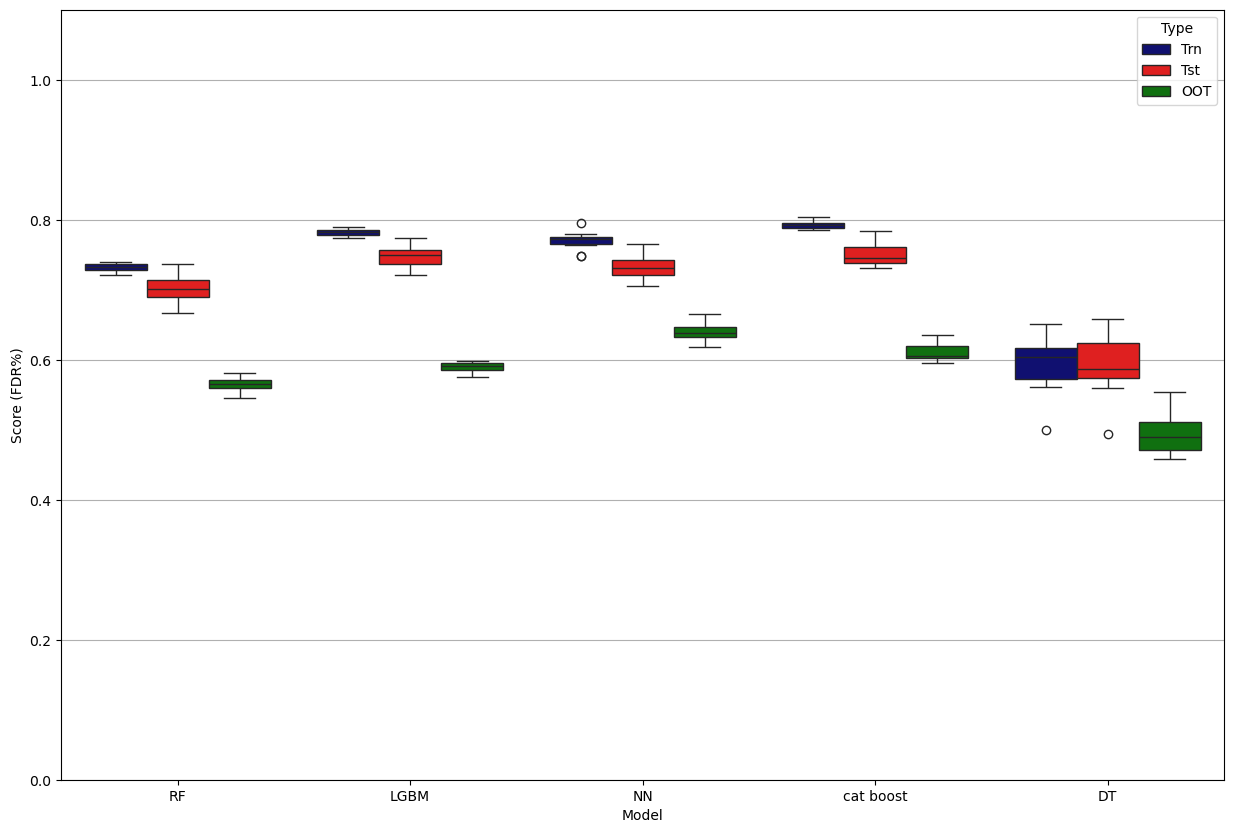

In [49]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(15,10))
ax = sns.boxplot(x='Model',y='Value',hue='Type', data=df_compare, palette=['navy','r','g'])

plt.ylim(0.,1.1)
plt.ylabel('Score (FDR%)')
plt.grid(axis='y')
plt.savefig('modeling.png')
plt.show()

In [50]:
print('duration: ', datetime.now() - start_time)

duration:  0:06:57.180341


This next cell can be used to explore overfitting

0 0.6872509960159362 0.6587301587301587 0.5814606741573034
1 0.6765847347994826 0.6813559322033899 0.5814606741573034
2 0.6889495225102319 0.6850746268656717 0.5898876404494382
loop trn tst oot 5 0.22808725036951674 0.22501785753324668 0.1947565543071161
0 0.676450967311541 0.6970172684458399 0.5617977528089888
1 0.6989690721649484 0.6475770925110133 0.5758426966292135
2 0.6871657754010695 0.6828125 0.5814606741573034
loop trn tst oot 10 0.22917620165306207 0.22526742899520594 0.1910112359550562
0 0.7151238591916558 0.7242524916943521 0.6235955056179775
1 0.7120418848167539 0.7220394736842105 0.5870786516853933
2 0.7054108216432866 0.7104851330203443 0.6095505617977528
loop trn tst oot 15 0.23695295173907738 0.23964189982210074 0.20224719101123595
0 0.736737400530504 0.7197452229299363 0.6123595505617978
1 0.7413333333333333 0.6729559748427673 0.6432584269662921
2 0.7178451178451178 0.695852534562212 0.598314606741573
loop trn tst oot 20 0.24399065018988392 0.23206152581499062 0.205992

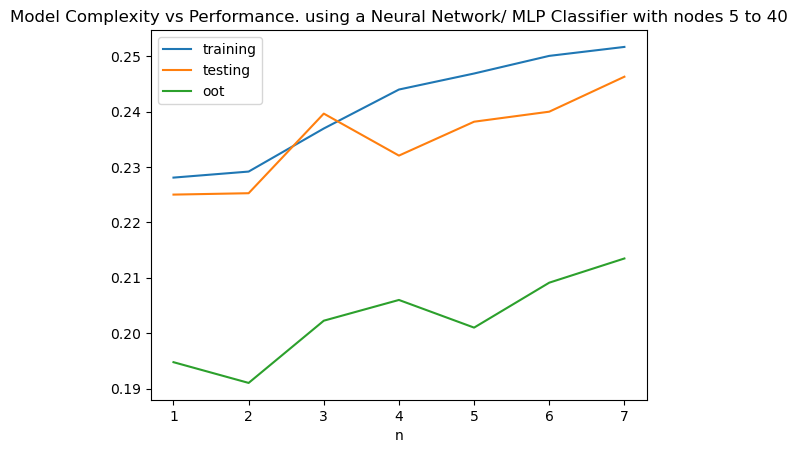

CPU times: user 3min 36s, sys: 1.49 s, total: 3min 38s
Wall time: 3min 3s


In [51]:
%%time
nitermax2 = 3 # let's reduce the number of runs to make it faster
training = []
testing = []
oot = []
results = pd.DataFrame(np.zeros((niter,3)),columns=['trn','tst','oot'])
for i in range(5,40,5):
    for niter in range(nitermax2):
        X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)
 
        model = MLPClassifier(
        hidden_layer_sizes=(i,10),
        activation='relu',
        solver='adam',
        alpha=0.01,
        learning_rate_init=0.0005,
        max_iter = 200
    )

        model.fit(X_trn, Y_trn.values.ravel()) 

        X_oot = X_oot_orig.copy()
        X_trn_save = X_trn.copy()
        Y_trn_save = Y_trn.copy()
    
        predictions = model.predict_proba(X_trn_save)[:,1]
        X_trn['predicted'] = predictions
        X_trn['Fraud'] = Y_trn_save['Fraud']
        topRows = int(round(X_trn.shape[0]*detect_rate))
        temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
        needed = temp.loc[:,'Fraud']
        results.loc[niter,'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

        predictions = model.predict_proba(X_tst)[:,1]
        X_tst['predicted']=predictions
        X_tst['Fraud'] = Y_tst['Fraud']
        topRows = int(round(X_tst.shape[0]*detect_rate))
        temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
        needed = temp.loc[:,'Fraud']
        results.loc[niter,'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

        predictions = model.predict_proba(X_oot)[:,1]
        X_oot['predicted']=predictions
        X_oot['Fraud'] = Y_oot['Fraud']
        topRows = int(round(X_oot.shape[0]*detect_rate))
        temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
        needed = temp.loc[:,'Fraud']
        results.loc[niter,'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
        print(niter, results.loc[niter,'trn'],results.loc[niter,'tst'],results.loc[niter,'oot'],)

    results_mean_trn = results['trn'].mean()
    results_mean_tst = results['tst'].mean()
    results_mean_oot = results['oot'].mean()
    print('loop', 'trn', 'tst', 'oot', i, results_mean_trn, results_mean_tst, results_mean_oot)
    training.append(results_mean_trn)
    testing.append(results_mean_tst)
    oot.append(results_mean_oot)

table=pd.DataFrame({'n': range(1,len(training)+1),'training':training,'testing':testing,'oot':oot})
table.set_index('n',inplace=True) 
table.plot()
plt.title('Model Complexity vs Performance. using a Neural Network/ MLP Classifier with nodes 5 to 40') 
plt.savefig('complexity_NN.pdf', format='pdf')
plt.show()

In [52]:
best_OOT

0.6657303370786517

The rest of the notebook makes the tables for your final model of choice. You need to run that final model only once (no CV). If you want you can run the below cell over and over by itself until it gives you a model you like (due to the stochastic nature of some ML algorithms, but you can't change from your best hyperparameters.

In [53]:
%%time
# Note - need to set this next value to around the highest oot fdr for your model of choice.
# The model then runs a nomber of times with your fixed hyperparameters until it finds a good model.
desire = best_OOT * .95
desire = .57
print('desire =', desire)
for niter in range(50):    
    X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

# here's where you put your final model of choice
# I run this loop a large number of times with an unreasonably high stopping criterion (the break condition)
# I then look at all these runs and select a value of the oot performance where I want to break out this loop
# and that will be my final model run of choice
    model = MLPClassifier(
        hidden_layer_sizes=(30,10),
        activation='relu',
        solver='adam',
        alpha=0.01,
        learning_rate_init=0.0005,
        max_iter = 200
    )

    X_oot = X_oot_orig.copy()
    X_trn_save = X_trn.copy()
    Y_trn_save = Y_trn.copy()

    model.fit(X_trn, Y_trn.values.ravel())   

    predictions = model.predict_proba(X_trn_save)[:,1]
    X_trn['predicted'] = predictions
    X_trn['Fraud'] = Y_trn_save['Fraud']
    topRows = int(round(X_trn.shape[0]*detect_rate))
    temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

    predictions = model.predict_proba(X_tst)[:,1]
    X_tst['predicted']=predictions
    X_tst['Fraud'] = Y_tst['Fraud']
    topRows = int(round(X_tst.shape[0]*detect_rate))
    temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

    predictions = model.predict_proba(X_oot)[:,1]
    X_oot['predicted']=predictions
    X_oot['Fraud'] = Y_oot['Fraud']
    topRows = int(round(X_oot.shape[0]*detect_rate))
    temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
    print(niter, FDR.loc[niter, 'trn'],FDR.loc[niter, 'tst'],FDR.loc[niter, 'oot'])
    Modeling_output.iloc[counter] = ['LGBM',FDR.loc[niter, 'trn'],FDR.loc[niter, 'tst'],FDR.loc[niter, 'oot']]
    counter = counter + 1
# choose a good break point
    if(FDR.loc[niter, 'oot'] > desire): break
    
model_counter = model_counter + 1

desire = 0.57
0 0.7372498386055519 0.737649063032368 0.6067415730337079
CPU times: user 14 s, sys: 12.3 ms, total: 14 s
Wall time: 13.6 s


In [54]:
X_trn_eval = X_trn.copy()
X_tst_eval = X_tst.copy()
X_oot_eval = X_oot.copy()

In [55]:
cols = ['bin','#recs','#g','#b','%g','%b','tot','cg','cb','%cg','FDR','KS','FPR']
FDR_trn = pd.DataFrame(np.zeros((101, 13)), columns = cols)
FDR_tst = pd.DataFrame(np.zeros((101, 13)), columns = cols)
FDR_oot = pd.DataFrame(np.zeros((101, 13)), columns = cols)
trn_sorted = X_trn_eval.sort_values('predicted',ascending=False)
tst_sorted = X_tst_eval.sort_values('predicted',ascending=False)
oot_sorted = X_oot_eval.sort_values('predicted',ascending=False)
bad_tot_trn = sum(X_trn_eval.loc[:, 'Fraud'])
bad_tot_tst = sum(X_tst_eval.loc[:, 'Fraud'])
bad_tot_oot = sum(X_oot_eval.loc[:, 'Fraud'])
num_tot_trn = len(X_trn_eval)
num_tot_tst = len(X_tst_eval)
num_tot_oot = len(X_oot_eval)
good_tot_trn = num_tot_trn - bad_tot_trn
good_tot_tst = num_tot_tst - bad_tot_tst
good_tot_oot = num_tot_oot - bad_tot_oot
oot_sorted.head(20)

,Cardnum_unique_count_for_card_state_1,card_state_total_3,card_state_total_amount_1_by_60,Cardnum_max_14,card_zip_count_1_by_60,card_state_count_1_by_30_sq,Cardnum_count_0_by_60_sq,Card_dow_unique_count_for_state_des_30,Card_dow_unique_count_for_merch_state_14,Card_dow_unique_count_for_merch_zip_14,Card_dow_total_60,Card_dow_unique_count_for_merch_state_30,Card_dow_unique_count_for_merch_zip_30,predicted,Fraud
90677,-0.462456,21.009360,1.299601,4.368159,0.91976,1.148172,1.340656,-0.133536,-0.591096,-0.591614,3.222569,-0.690354,-0.690846,0.998364,1.0
90624,-0.462456,19.695250,1.299601,4.368159,0.91976,1.148172,1.058663,-0.133536,-0.591096,-0.591614,2.715796,-0.690354,-0.690846,0.998357,1.0
90680,-0.462456,21.109878,1.299601,4.368159,0.91976,1.148172,1.423595,-0.133536,-0.591096,-0.591614,3.261333,-0.690354,-0.690846,0.998315,1.0
90628,-0.462456,19.849488,1.299601,4.368159,0.91976,1.148172,1.158725,-0.133536,-0.591096,-0.591614,2.775276,-0.690354,-0.690846,0.998303,1.0
90668,-0.462456,20.132557,1.299601,4.368159,0.91976,1.148172,1.252533,-0.133536,-0.591096,-0.591614,2.884439,-0.690354,-0.690846,0.998278,1.0
90623,-0.462456,15.403125,1.299601,1.498931,0.91976,1.148172,0.951700,-0.133536,-0.591096,-0.591614,1.060582,-0.690354,-0.690846,0.996683,1.0
90608,-0.462456,13.719897,1.299601,1.498931,0.91976,1.148172,0.283182,-0.431842,-0.591096,-0.591614,0.411463,-0.690354,-0.690846,0.995787,1.0
90611,-0.462456,13.933830,1.299601,1.498931,0.91976,1.148172,0.438278,-0.431842,-0.591096,-0.591614,0.493964,-0.690354,-0.690846,0.995787,1.0
90615,-0.462456,14.966009,1.299601,1.498931,0.91976,1.148172,0.714005,-0.431842,-0.591096,-0.591614,0.892013,-0.690354,-0.690846,0.995690,1.0
90614,-0.462456,14.117318,1.299601,1.498931,0.91976,1.148172,0.581444,-0.431842,-0.591096,-0.591614,0.564724,-0.690354,-0.690846,0.995573,1.0


In [56]:
cost_fraud = 400
cost_fp = 20
for i in range(101):
    percent_rows_trn = int(round(X_trn_eval.shape[0]*0.01*i))
    percent_rows_tst = int(round(X_tst_eval.shape[0]*0.01*i))
    percent_rows_oot = int(round(X_oot_eval.shape[0]*0.01*i))
    temp_trn = trn_sorted.head(percent_rows_trn)
    temp_tst = tst_sorted.head(percent_rows_tst)
    temp_oot = oot_sorted.head(percent_rows_oot)
    num_bad_trn = sum(temp_trn.loc[:,'Fraud'])
    num_bad_tst = sum(temp_tst.loc[:,'Fraud'])
    num_bad_oot = sum(temp_oot.loc[:,'Fraud'])
    num_tot_trn = len(temp_trn)
    num_tot_tst = len(temp_tst)
    num_tot_oot = len(temp_oot)
    num_good_trn = num_tot_trn - num_bad_trn
    num_good_tst = num_tot_tst - num_bad_tst
    num_good_oot = num_tot_oot - num_bad_oot
    
    FDR_trn.loc[i, 'bin'] = i
    FDR_trn.loc[i,'#recs'] = 0
    FDR_trn.loc[i, 'tot'] = num_tot_trn
    FDR_trn.loc[i, 'cg'] = num_good_trn
    FDR_trn.loc[i, 'cb'] = num_bad_trn
    FDR_trn.loc[i, 'Fraud Savings'] = FDR_trn.loc[i, 'cb'] * cost_fraud
    FDR_trn.loc[i, 'FP Loss'] = FDR_trn.loc[i, 'cg'] * cost_fp
    FDR_trn.loc[i, 'Overall Savings'] = FDR_trn.loc[i, 'Fraud Savings'] - FDR_trn.loc[i, 'FP Loss']
    FDR_tst.loc[i, 'bin'] = i
    FDR_tst.loc[i, 'tot'] = num_tot_tst
    FDR_tst.loc[i, 'cg'] = num_good_tst
    FDR_tst.loc[i, 'cb'] = num_bad_tst
    FDR_tst.loc[i, 'Fraud Savings'] = FDR_tst.loc[i, 'cb'] * cost_fraud
    FDR_tst.loc[i, 'FP Loss'] = FDR_tst.loc[i, 'cg'] * cost_fp
    FDR_tst.loc[i, 'Overall Savings'] = FDR_tst.loc[i, 'Fraud Savings'] - FDR_tst.loc[i, 'FP Loss']
    FDR_oot.loc[i, 'bin'] = i
    FDR_oot.loc[i, 'tot'] = num_tot_oot
    FDR_oot.loc[i, 'cg'] = num_good_oot
    FDR_oot.loc[i, 'cb'] = num_bad_oot

    if i != 0:
        FDR_trn.loc[i, '#g'] = num_good_trn - FDR_trn.loc[i-1, 'cg']
        FDR_trn.loc[i, '#b'] = num_bad_trn - FDR_trn.loc[i-1, 'cb']
        FDR_trn.loc[i,'#recs'] = FDR_trn.loc[i, '#g'] + FDR_trn.loc[i, '#b']
        FDR_trn.loc[i, '%g'] = 100* (num_good_trn - FDR_trn.loc[i-1, 'cg']) / (num_tot_trn - FDR_trn.loc[i-1, 'tot'])
        FDR_trn.loc[i, '%b'] = 100 - FDR_trn.loc[i, '%g']
        FDR_trn.loc[i, '%cg'] = 100 * num_good_trn / good_tot_trn
        FDR_trn.loc[i, 'FDR'] = 100 * num_bad_trn / bad_tot_trn
        FDR_trn.loc[i, 'KS'] = FDR_trn.loc[i, 'FDR'] - FDR_trn.loc[i, '%cg']
        FDR_trn.loc[i, 'FPR'] = num_good_trn / num_bad_trn
        FDR_tst.loc[i, '#g'] = num_good_tst - FDR_tst.loc[i-1, 'cg']
        FDR_tst.loc[i, '#b'] = num_bad_tst - FDR_tst.loc[i-1, 'cb']
        FDR_tst.loc[i,'#recs'] = FDR_tst.loc[i, '#g'] + FDR_tst.loc[i, '#b']
        FDR_tst.loc[i, '%g'] = 100* (num_good_tst - FDR_tst.loc[i-1, 'cg']) / (num_tot_tst - FDR_tst.loc[i-1, 'tot'])
        FDR_tst.loc[i, '%b'] = 100 - FDR_tst.loc[i, '%g']
        FDR_tst.loc[i, '%cg'] = 100 * num_good_tst / good_tot_tst
        FDR_tst.loc[i, 'FDR'] = 100 * num_bad_tst / bad_tot_tst
        FDR_tst.loc[i, 'KS'] = FDR_tst.loc[i, 'FDR'] - FDR_tst.loc[i, '%cg']
        FDR_tst.loc[i, 'FPR'] = num_good_tst / num_bad_tst
        FDR_oot.loc[i, '#g'] = num_good_oot - FDR_oot.loc[i-1, 'cg']
        FDR_oot.loc[i, '#b'] = num_bad_oot - FDR_oot.loc[i-1, 'cb']
        FDR_oot.loc[i,'#recs'] = FDR_oot.loc[i, '#g'] + FDR_oot.loc[i, '#b']
        FDR_oot.loc[i, '%g'] = 100* (num_good_oot - FDR_oot.loc[i-1, 'cg']) / (num_tot_oot - FDR_oot.loc[i-1, 'tot'])
        FDR_oot.loc[i, '%b'] = 100 - FDR_oot.loc[i, '%g']
        FDR_oot.loc[i, '%cg'] = 100 * num_good_oot / good_tot_oot
        FDR_oot.loc[i, 'FDR'] = 100 * num_bad_oot / bad_tot_oot
        FDR_oot.loc[i, 'KS'] = FDR_oot.loc[i, 'FDR'] - FDR_oot.loc[i, '%cg']
        FDR_oot.loc[i, 'FPR'] = num_good_oot / num_bad_oot

FDR_oot

,bin,#recs,#g,#b,%g,%b,tot,cg,cb,%cg,FDR,KS,FPR
0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000
1,1.0,126.0,19.0,107.0,15.079365,84.920635,126.0,19.0,107.0,0.154711,30.056180,29.901469,0.177570
2,2.0,127.0,60.0,67.0,47.244094,52.755906,253.0,79.0,174.0,0.643270,48.876404,48.233134,0.454023
3,3.0,126.0,84.0,42.0,66.666667,33.333333,379.0,163.0,216.0,1.327253,60.674157,59.346904,0.754630
4,4.0,126.0,95.0,31.0,75.396825,24.603175,505.0,258.0,247.0,2.100806,69.382022,67.281216,1.044534
...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,96.0,127.0,127.0,0.0,100.000000,0.000000,12132.0,11776.0,356.0,95.887957,100.000000,4.112043,33.078652
97,97.0,126.0,126.0,0.0,100.000000,0.000000,12258.0,11902.0,356.0,96.913932,100.000000,3.086068,33.432584
98,98.0,126.0,126.0,0.0,100.000000,0.000000,12384.0,12028.0,356.0,97.939907,100.000000,2.060093,33.786517
99,99.0,127.0,127.0,0.0,100.000000,0.000000,12511.0,12155.0,356.0,98.974025,100.000000,1.025975,34.143258


Max possible savings: 61,200,000.0


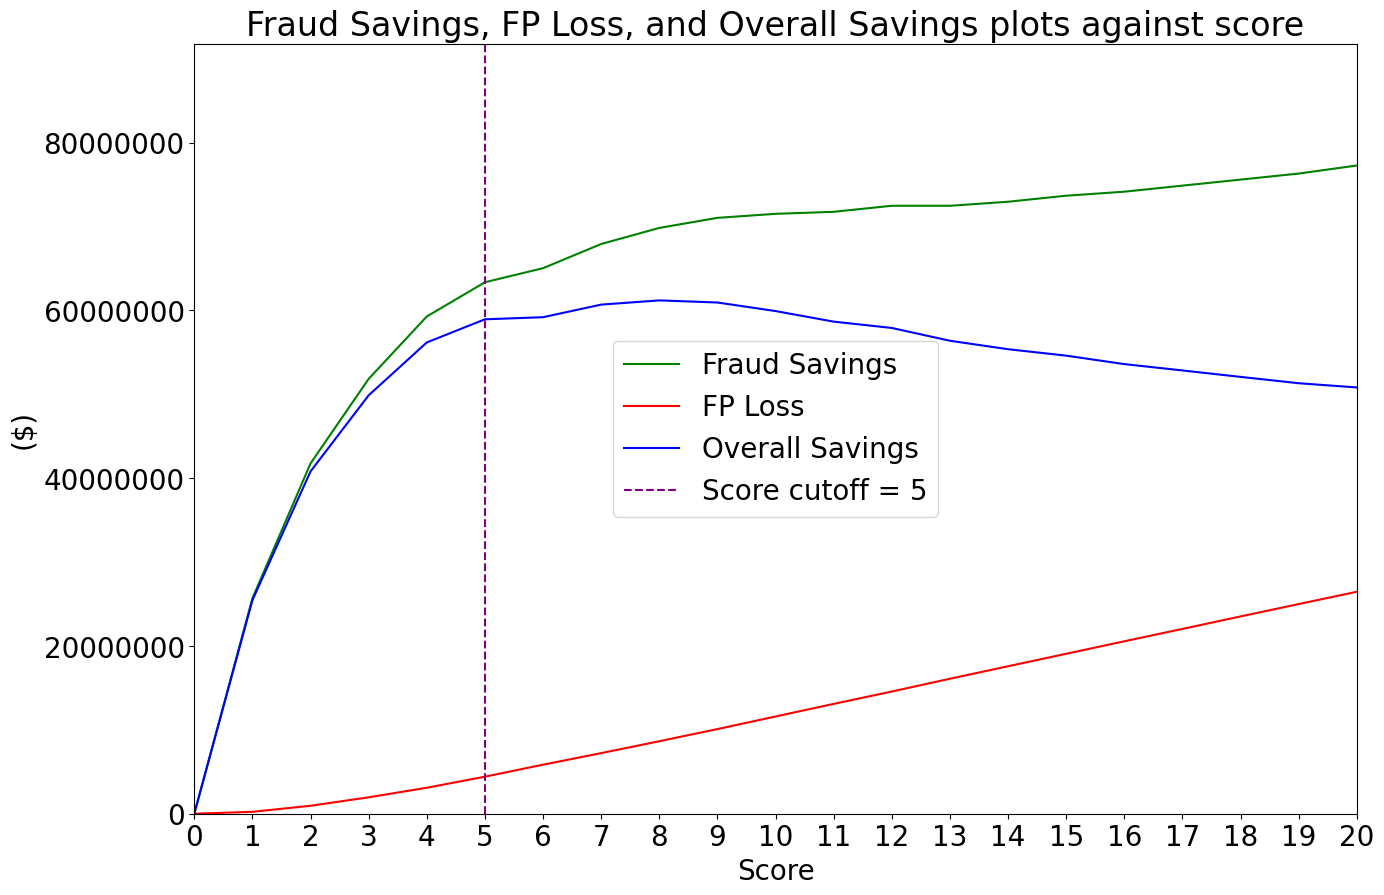

In [ ]:
# # xmult: oot is only 2 out of 12 months. 100,000 sample transactions out of 10 million/year
xoot = 12/2 * 10000000/100000
Financials_trn = pd.DataFrame(np.zeros((101, 3)), columns = ['Fraud Savings','FP Loss','Overall Savings'])
Financials_tst = pd.DataFrame(np.zeros((101, 3)), columns = ['Fraud Savings','FP Loss','Overall Savings'])
Financials_oot = pd.DataFrame(np.zeros((101, 3)), columns = ['Fraud Savings','FP Loss','Overall Savings'])
for i in range(101):
    Financials_trn.loc[i, 'Fraud Savings'] = FDR_trn.loc[i, 'cb'] * cost_fraud * xoot
    Financials_trn.loc[i, 'FP Loss'] = FDR_trn.loc[i, 'cg'] * cost_fp * xoot
    Financials_trn.loc[i, 'Overall Savings'] = Financials_trn.loc[i, 'Fraud Savings'] - Financials_trn.loc[i, 'FP Loss']
    Financials_tst.loc[i, 'Fraud Savings'] = FDR_tst.loc[i, 'cb'] * cost_fraud * xoot
    Financials_tst.loc[i, 'FP Loss'] = FDR_tst.loc[i, 'cg'] * cost_fp * xoot
    Financials_tst.loc[i, 'Overall Savings'] = Financials_tst.loc[i, 'Fraud Savings'] - Financials_tst.loc[i, 'FP Loss']
    Financials_oot.loc[i, 'Fraud Savings'] = FDR_oot.loc[i, 'cb'] * cost_fraud * xoot
    Financials_oot.loc[i, 'FP Loss'] = FDR_oot.loc[i, 'cg'] * cost_fp * xoot
    Financials_oot.loc[i, 'Overall Savings'] = Financials_oot.loc[i, 'Fraud Savings'] - Financials_oot.loc[i, 'FP Loss']

max_savings = Financials_oot['Overall Savings'].max(0)
print('Max possible savings: '+'{:,}'.format(max_savings))
yupper = max_savings * 1.5
plt.rcParams.update({'font.size':20})
plt.figure(figsize=(15,10))
plt.plot(Financials_oot['Fraud Savings'], color='green', label='Fraud Savings')
plt.plot(Financials_oot['FP Loss'], color='red', label='FP Loss')
plt.plot(Financials_oot['Overall Savings'], color='blue', label='Overall Savings')
xlimit = 20
interval = 1
plt.axvline(x=5, color='purple', linestyle='--', label='Score cutoff = 5')  # Add vertical line
plt.xlim(0,xlimit)
plt.ylim(0,yupper)
plt.xticks(ticks=np.linspace(0,xlimit, num=int(xlimit/interval)+1))
plt.ticklabel_format(style='plain')
plt.xlabel('Score')
plt.ylabel('($)')
plt.title("Fraud Savings, FP Loss, and Overall Savings plots against score")
plt.legend()
plt.savefig('savings.png', format='png')
plt.show()

In [117]:
blue_curve_value = Financials_oot.loc[5, 'Overall Savings']
blue_curve_value

58944000.0

In [58]:
FDR_oot.head(10)

,bin,#recs,#g,#b,%g,%b,tot,cg,cb,%cg,FDR,KS,FPR
0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000
1,1.0,126.0,19.0,107.0,15.079365,84.920635,126.0,19.0,107.0,0.154711,30.056180,29.901469,0.177570
2,2.0,127.0,60.0,67.0,47.244094,52.755906,253.0,79.0,174.0,0.643270,48.876404,48.233134,0.454023
3,3.0,126.0,84.0,42.0,66.666667,33.333333,379.0,163.0,216.0,1.327253,60.674157,59.346904,0.754630
4,4.0,126.0,95.0,31.0,75.396825,24.603175,505.0,258.0,247.0,2.100806,69.382022,67.281216,1.044534
5,5.0,127.0,110.0,17.0,86.614173,13.385827,632.0,368.0,264.0,2.996499,74.157303,71.160805,1.393939
6,6.0,126.0,119.0,7.0,94.444444,5.555556,758.0,487.0,271.0,3.965475,76.123596,72.158120,1.797048
7,7.0,127.0,115.0,12.0,90.551181,9.448819,885.0,602.0,283.0,4.901881,79.494382,74.592501,2.127208
8,8.0,126.0,118.0,8.0,93.650794,6.349206,1011.0,720.0,291.0,5.862715,81.741573,75.878858,2.474227
9,9.0,126.0,121.0,5.0,96.031746,3.968254,1137.0,841.0,296.0,6.847977,83.146067,76.298091,2.841216


In [59]:
FDR.to_csv('FDR.csv')

In [60]:
FDR_trn.to_csv('FDR_trn.csv', index=False)
FDR_tst.to_csv('FDR_tst.csv', index=False)
FDR_oot.to_csv('FDR_oot.csv', index=False)

In [61]:
Metrics = FDR_oot.copy()
num_good = Metrics['#g'].sum()
num_bad = Metrics['#b'].sum()
num_tot = Metrics['#recs'].sum()
print(num_good,num_bad,num_good+num_bad,num_tot)

12281.0 356.0 12637.0 12637.0


In [62]:
Metrics['TP'] = Metrics['cb']
Metrics['TN'] = num_good - Metrics['cg']
Metrics['FN'] = num_bad - Metrics['cb']
Metrics['FP'] = Metrics['cg']
Metrics['Accuracy'] = (Metrics['TP'] + Metrics['TN']) / num_tot
Metrics['Misclass'] = (Metrics['FP'] + Metrics['FN']) / num_tot
Metrics['FPRate'] = Metrics['FP'] / (Metrics['FP'] + Metrics['TN'])
Metrics['FPRatio'] = Metrics['FP'] / Metrics['TP']
Metrics['TPR'] = Metrics['TP'] / (Metrics['TP'] + Metrics['FN'])
Metrics['TNR'] = Metrics['TN'] / (Metrics['TN'] + Metrics['FP'])
Metrics['Precision'] = Metrics['TP'] / (Metrics['TP'] + Metrics['FP'])
Metrics['f1'] = 2 * Metrics['Precision'] * Metrics['TPR'] / (Metrics['Precision'] + Metrics['TPR'])
Metrics.to_csv('Metrics.csv')

Text(0, 0.5, 'FDR')

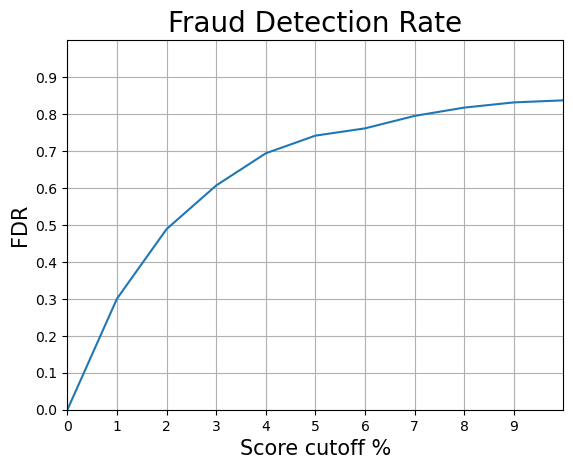

In [63]:
plt.rcParams.update({'font.size':10})
plt.plot(Metrics['bin'], Metrics['TPR'])
plt.title('Fraud Detection Rate', fontsize=20)
plt.xlim(0,10)
plt.ylim(0,1)
plt.xticks(np.arange(0, 10, step=1))
plt.yticks(np.arange(0,1,step=.1))
plt.grid()
plt.xlabel('Score cutoff %', fontsize=15)
plt.ylabel('FDR', fontsize=15)

For a highly imbalanced problem the # goods in each bin is close to constant except for the first few bins, so the FDR curve (xaxis is bin #) and the ROC (x axis is FP, which is # goods below the cutoff) look very similar. They're only different in the first few bins where the # goods are not ~constant.

(0.0, 1.0)

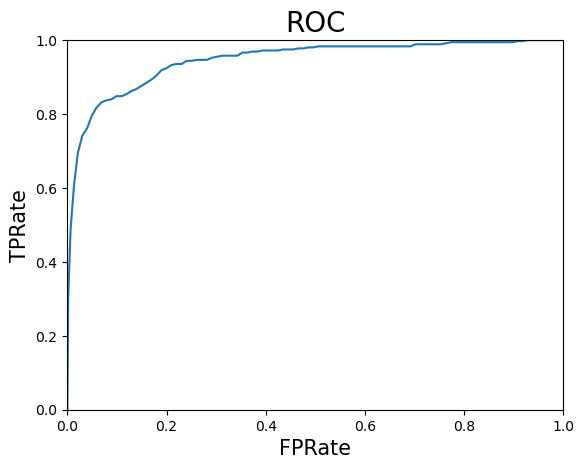

In [64]:
plt.plot(Metrics['FPRate'], Metrics['TPR'])
plt.title('ROC', fontsize=20)
plt.xlabel('FPRate',fontsize=15)
plt.ylabel('TPRate', fontsize=15)
plt.xlim(0,1)
plt.ylim(0,1)

In [65]:
print("duration: ", datetime.now() - start_time)

duration:  0:10:16.342269


In [66]:
%pwd

'/mnt/c/Users/nitya/OneDrive/Desktop/nvrsm/fraud analytics'

In [67]:
%%time
df = pd.read_csv('card transactions_2025.csv')
df.dropna(how='all', axis=1, inplace=True)
df = df[df['Transtype'] == 'P']
df = df[df['Amount'] <= 3000000]
df['Date'] = pd.to_datetime(df['Date'])
df.shape

CPU times: user 255 ms, sys: 16.9 ms, total: 272 ms
Wall time: 459 ms


<timed exec>:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.


(98037, 10)

In [68]:
df['prediction'] = model.predict_proba(X)[:,1]

In [69]:
pred_scale = 1/df['prediction'].max()
df['prediction'] = df['prediction']*pred_scale

In [70]:
df.head()

,Recnum,Cardnum,Date,Merchnum,Merch description,Merch state,Merch zip,Transtype,Amount,Fraud,prediction
0,1,5142190439,2010-01-01,5509006296254,FEDEX SHP 12/23/09 AB#,TN,38118.0,P,3.62,0,0.003649
1,2,5142183973,2010-01-01,61003026333,SERVICE MERCHANDISE #81,MA,1803.0,P,31.42,0,0.003899
2,3,5142131721,2010-01-01,4503082993600,OFFICE DEPOT #191,MD,20706.0,P,178.49,0,0.005484
3,4,5142148452,2010-01-01,5509006296254,FEDEX SHP 12/28/09 AB#,TN,38118.0,P,3.62,0,0.003649
4,5,5142190439,2010-01-01,5509006296254,FEDEX SHP 12/23/09 AB#,TN,38118.0,P,3.62,0,0.003700


In [71]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 98037 entries, 0 to 98392
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Recnum             98037 non-null  int64         
 1   Cardnum            98037 non-null  int64         
 2   Date               98037 non-null  datetime64[ns]
 3   Merchnum           94791 non-null  object        
 4   Merch description  98037 non-null  object        
 5   Merch state        97000 non-null  object        
 6   Merch zip          93664 non-null  float64       
 7   Transtype          98037 non-null  object        
 8   Amount             98037 non-null  float64       
 9   Fraud              98037 non-null  int64         
 10  prediction         98037 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(3), object(4)
memory usage: 9.0+ MB


In [72]:
df_sorted = df.sort_values(by=['prediction'],ascending=False)
df_sorted.head(20)

,Recnum,Cardnum,Date,Merchnum,Merch description,Merch state,Merch zip,Transtype,Amount,Fraud,prediction
81973,81974,5142183973,2010-10-07,6005030600003,FORMA SCIENTIFIC,OH,45750.0,P,2050.09,1,1.000000
81937,81938,5142183973,2010-10-07,6005030600003,FORMA SCIENTIFIC,OH,45750.0,P,2092.55,1,0.999930
81917,81918,5142183973,2010-10-07,6005030600003,FORMA SCIENTIFIC,OH,45750.0,P,1947.85,1,0.999841
81982,81983,5142183973,2010-10-07,6005030600003,FORMA SCIENTIFIC,OH,45750.0,P,2051.21,1,0.999747
81912,81913,5142183973,2010-10-07,6005030600003,FORMA SCIENTIFIC,OH,45750.0,P,2020.04,1,0.999699
81900,81901,5142183973,2010-10-07,6005030600003,FORMA SCIENTIFIC,OH,45750.0,P,2096.45,1,0.999428
81892,81893,5142183973,2010-10-07,6005030600003,FORMA SCIENTIFIC,OH,45750.0,P,1936.09,1,0.999016
71951,71952,5142220919,2010-09-06,5900000064440,PROFESSIONAL IMAGE,IL,60532.0,P,4803.26,1,0.998784
36570,36571,5142271065,2010-05-15,4620009957157,DSI TERMITE & PEST CON,MD,20607.0,P,548.32,1,0.998738
36566,36567,5142271065,2010-05-15,4620009957157,DSI TERMITE & PEST CON,MD,20607.0,P,1006.57,1,0.998723


# Here we're going to look at specific cards or merchants to look at the dynamics of the fraud score

In [73]:
bads = df[df['Fraud']==1]
bads['Cardnum'].value_counts().head(20)

Cardnum
5142214614    60
5142271065    58
5142140316    46
5142847398    45
5142199009    45
5142219623    44
5142220474    42
5142223373    42
5142197711    42
5142160778    41
5142189341    41
5142225942    41
5142181728    39
5142212038    39
5142220919    38
5142165136    37
5142202847    37
5142223659    36
5142138135    36
5142226204    35
Name: count, dtype: int64

In [74]:
bads['Merchnum'].value_counts().head(15)

Merchnum
930090121224     205
4353000719908    118
9900020006406     51
9108234610000     50
8834000695423     46
4503738417400     45
4620009957157     41
4503082476300     40
900009045549      37
618901687330      36
253052983001      35
938909877224      32
6006333528866     30
997674930332      30
6070095870009     28
Name: count, dtype: int64

In [75]:
card = 5142140316
# card = 5142847398
# card = 5142199009
# card = 5142160778
# card = 5142189341
# card = 5142181728
# card = 5142212038
# card = 5142220919
# card = 5142214614
# card = 5142202847
# card = 5142138135
# card = 5142271065
# card = 5142152857
# card = 5142179617
# card = 5142235211
# card = 5142197711
# card = 5142182128
# card = 5142189113
# card = 5142197563 

merch = 4353000719908
# merch = 930090121224  
# merch = 48834000695423
# merch = 44503738417400
# merch = 44620009957157
# merch = 4618901687330
# merch = 4900009045549
# merch = 49108234610000
# merch = 4253052983001
# merch = 4938909877224
# merch = 44503082476300
# merch = 46006333528866
# merch = 4997674930332
# merch = 46070095870009
# merch = 49900020006406
sample = df[df['Cardnum'] == card]
# sample = df[df['Merchnum'] == str(merch)]
sample['Fraud'].sum()

46

/tmp/ipykernel_58160/2861435870.py:4: MatplotlibDeprecationWarning: The plot_date function was deprecated in Matplotlib 3.9 and will be removed in 3.11. Use plot instead.
  plt.plot_date(sample['Date'],sample['Fraud'])


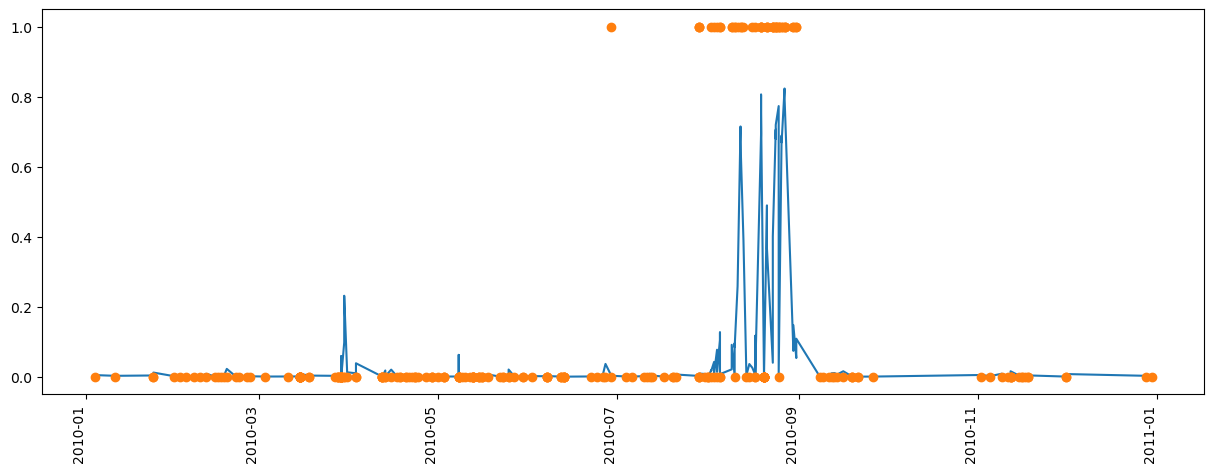

In [76]:
plt.figure(figsize=(15,5))
plt.xticks(rotation=90, ha='right')
plt.plot(sample['Date'],sample['prediction'])
plt.plot_date(sample['Date'],sample['Fraud'])

In [77]:
tsample = sample[sample['Date'] > '2010-08-01']
tsample = tsample[tsample['Date'] < '2010-09-10']
tsample.reset_index(inplace=True)
tsample.reset_index(inplace=True)
tsample.rename(columns={'level_0':'counter'},inplace=True)
tsample['counter'] = tsample['counter']+1
tsample.head()

,counter,index,Recnum,Cardnum,Date,Merchnum,Merch description,Merch state,Merch zip,Transtype,Amount,Fraud,prediction
0,1,59783,59784,5142140316,2010-08-02,8834000695423,STEVES COMPUTER REPAIR,CA,92656.0,P,2629.20,1,0.018530
1,2,60129,60130,5142140316,2010-08-02,4620002006336,HP GSA STORE,AZ,85285.0,P,644.00,0,0.016048
2,3,60239,60240,5142140316,2010-08-03,8834000695423,STEVES COMPUTER REPAIR,CA,92656.0,P,560.72,1,0.042113
3,4,60580,60581,5142140316,2010-08-03,465906341338,HEWLETT PACKARD CO,CA,95747.0,P,176.00,0,0.010281
4,5,60698,60699,5142140316,2010-08-04,8834000695423,STEVES COMPUTER REPAIR,CA,92656.0,P,487.26,1,0.076929


/tmp/ipykernel_58160/2407391654.py:4: MatplotlibDeprecationWarning: The plot_date function was deprecated in Matplotlib 3.9 and will be removed in 3.11. Use plot instead.
  plt.plot_date(tsample['Date'],tsample['Fraud'])


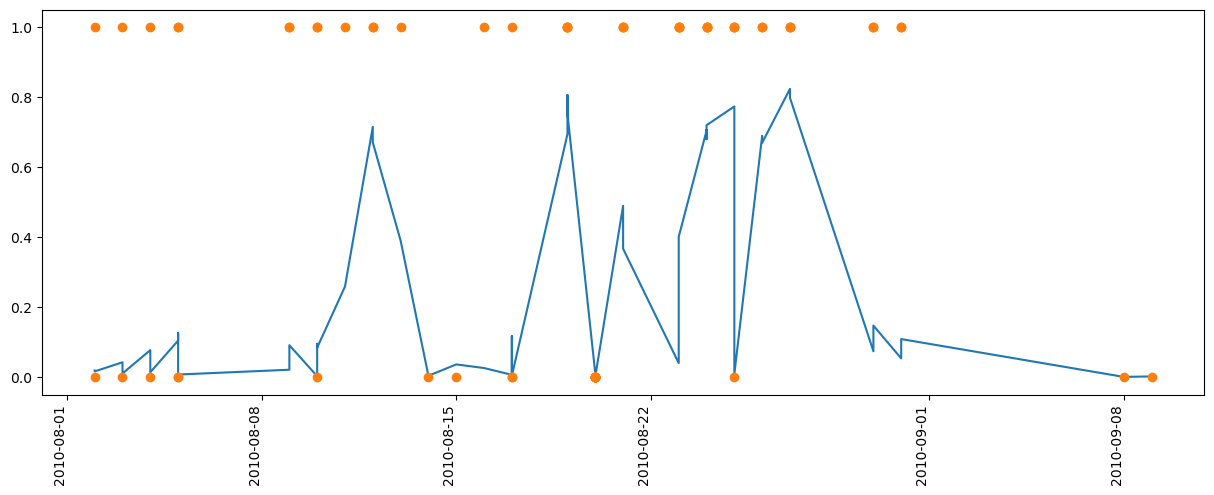

In [78]:
plt.figure(figsize=(15,5))
plt.xticks(rotation=90, ha='right')
plt.plot(tsample['Date'],tsample['prediction'])
plt.plot_date(tsample['Date'],tsample['Fraud'])
plt.savefig('dynamics_time.png', format='png')

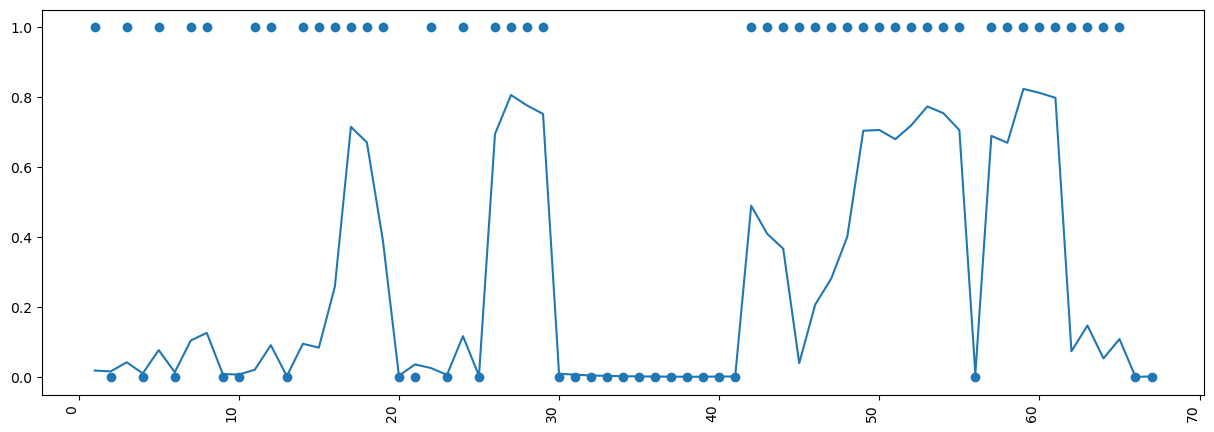

In [79]:
plt.figure(figsize=(15,5))
plt.xticks(rotation=90, ha='right')
plt.plot(tsample['counter'],tsample['prediction'])
plt.scatter(tsample['counter'],tsample['Fraud'])
plt.savefig('dynamics_count.png', format='png')

In [82]:
#tsample.to_csv('dynamics_transactions.csv')
tsample.head(40)

,counter,index,Recnum,Cardnum,Date,Merchnum,Merch description,Merch state,Merch zip,Transtype,Amount,Fraud,prediction
0,1,59783,59784,5142140316,2010-08-02,8834000695423,STEVES COMPUTER REPAIR,CA,92656.0,P,2629.20,1,0.018530
1,2,60129,60130,5142140316,2010-08-02,4620002006336,HP GSA STORE,AZ,85285.0,P,644.00,0,0.016048
2,3,60239,60240,5142140316,2010-08-03,8834000695423,STEVES COMPUTER REPAIR,CA,92656.0,P,560.72,1,0.042113
3,4,60580,60581,5142140316,2010-08-03,465906341338,HEWLETT PACKARD CO,CA,95747.0,P,176.00,0,0.010281
4,5,60698,60699,5142140316,2010-08-04,8834000695423,STEVES COMPUTER REPAIR,CA,92656.0,P,487.26,1,0.076929
5,6,60993,60994,5142140316,2010-08-04,4620002006336,HP GSA STORE,AZ,85285.0,P,1060.00,0,0.013606
6,7,61041,61042,5142140316,2010-08-05,8834000695423,STEVES COMPUTER REPAIR,CA,92656.0,P,629.09,1,0.104242
7,8,61044,61045,5142140316,2010-08-05,8834000695423,STEVES COMPUTER REPAIR,CA,92656.0,P,1821.05,1,0.126265
8,9,61111,61112,5142140316,2010-08-05,930090121224,FEDEX SHP 07/24/10 AB#,TN,38118.0,P,5.16,0,0.008455
9,10,61145,61146,5142140316,2010-08-05,930090121224,FEDEX SHP 07/21/10 AB#,TN,38118.0,P,3.57,0,0.007106


In [83]:
len(tsample)

67

# Score Calibration

In [84]:
base = 600
delta = 20
odds_at_base = .1

In [85]:
df = pd.concat([X_trn_eval,X_tst_eval,X_oot_eval])
df.shape

(98037, 15)

In [86]:
df.head()

,Cardnum_unique_count_for_card_state_1,card_state_total_3,card_state_total_amount_1_by_60,Cardnum_max_14,card_zip_count_1_by_60,card_state_count_1_by_30_sq,Cardnum_count_0_by_60_sq,Card_dow_unique_count_for_state_des_30,Card_dow_unique_count_for_merch_state_14,Card_dow_unique_count_for_merch_zip_14,Card_dow_total_60,Card_dow_unique_count_for_merch_state_30,Card_dow_unique_count_for_merch_zip_30,predicted,Fraud
6763,0.149025,-0.133690,1.299601,0.167690,0.919760,1.148172,-0.503960,-0.133536,-0.145788,-0.146518,-0.236049,-0.021142,-0.022007,0.013075,0.0
78484,1.371988,-0.048355,1.299601,0.811875,0.919760,1.148172,-0.192991,-0.133536,0.299521,0.298578,0.607396,0.313463,0.312412,0.010798,0.0
20041,-0.462456,-0.024615,0.289712,-0.609693,0.237211,-0.246748,0.242367,-0.431842,-0.145788,-0.146518,-0.443136,-0.355748,-0.356427,0.002952,0.0
15595,0.149025,-0.252676,1.299601,-0.291576,0.919760,1.148172,-0.588770,1.059685,0.299521,0.298578,-0.284831,1.317280,1.315670,0.001643,0.0
18738,0.149025,-0.284234,-1.108677,0.095296,-1.127887,-1.083701,-0.360436,0.164769,0.744829,0.743674,-0.170097,0.313463,0.312412,0.000602,0.0


In [87]:
calib = df.iloc[:,df.shape[1]-2:]
trn_sorted = X_trn_eval.sort_values('predicted',ascending=True)
calib = calib.sort_values('predicted')
calib.rename(columns={'predicted':'score_raw'}, inplace=True)
calib['score_raw'].clip(upper=.999, inplace=True)
calib['score_raw'].clip(lower=.00001, inplace=True)
calib.head()

/tmp/ipykernel_58160/1461524955.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  calib['score_raw'].clip(upper=.999, inplace=True)
/tmp/ipykernel_58160/1461524955.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', t

,score_raw,Fraud
26418,0.00001,0.0
26457,0.00001,0.0
22480,0.00001,0.0
26289,0.00001,0.0
40357,0.00001,0.0


In [88]:
calib.shape

(98037, 2)

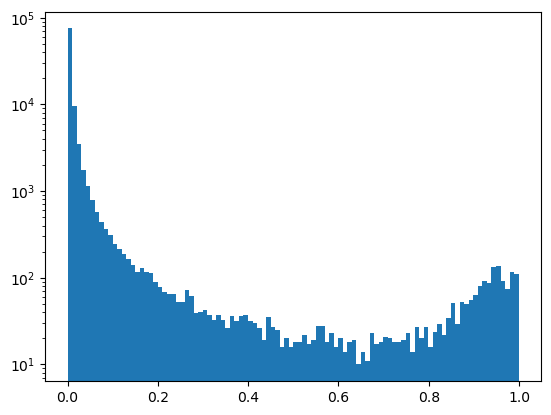

In [89]:
plt.hist(calib['score_raw'],bins=100)
plt.yscale('log')

In [90]:
# The reason we bin the records is to calculate the odds. We can then find the relationship between the raw score and the log odds.
nbins=100
cols = ['bin','#recs','#g','#b','%g','%b','tot','cg','cb','score_raw','prob(%)','odds','log_odds', 'log_odds_adj']
cal_bins = pd.DataFrame(np.zeros((nbins+1, 14)), columns = cols)

In [91]:
bad_tot = sum(calib.loc[:, 'Fraud'])
good_tot = len(calib) - bad_tot
print(bad_tot, good_tot)

2492.0 95545.0


In [92]:
frac = 1/nbins
nrecs = calib.shape[0]
cal_bins.loc[0,'log_odds_adj'] = -8
for i in range(nbins+1):
    percent_rows_top = int(round(nrecs*frac*i))
    percent_rows_bottom = max(int(round(nrecs*frac*(i-1))),0)
    temp = calib.iloc[percent_rows_bottom:percent_rows_top,:]
    cal_bins.loc[i, 'score_raw'] = temp['score_raw'].mean()
    num_bad = int(sum(temp.loc[:,'Fraud']))
    num_tot = len(temp) * i
    num_good = int(num_tot - num_bad)
    cal_bins.loc[i, 'bin'] = i
    cal_bins.loc[i,'#recs'] = 0
    cal_bins.loc[i, 'tot'] = num_tot
    cal_bins.loc[i, 'cg'] = num_good
    cal_bins.loc[i, 'cb'] = num_bad
    if i != 0:
        cal_bins.loc[i, '#recs'] = len(temp)
        cal_bins.loc[i, '#b'] = int(sum(temp.loc[:, 'Fraud']))
        cal_bins.loc[i, '#g'] = cal_bins.loc[i, '#recs'] - cal_bins.loc[i, '#b']
        cal_bins.loc[i, '%g'] = 100* cal_bins.loc[i, '#g'] / cal_bins.loc[i, '#recs']
        cal_bins.loc[i, '%b'] = 100 - cal_bins.loc[i, '%g']
        cal_bins.loc[i, 'cg'] = cal_bins.loc[i-1, 'cg'] + cal_bins.loc[i, '#g']
        cal_bins.loc[i, 'cb'] = cal_bins.loc[i-1, 'cb'] + cal_bins.loc[i, '#b']
        cal_bins.loc[i, 'prob(%)'] = 100 * cal_bins.loc[i, '#b'] / cal_bins.loc[i, '#recs']
        cal_bins.loc[i, 'odds'] = (cal_bins.loc[i, '#b'] + .001) / cal_bins.loc[i, '#g']
        cal_bins.loc[i, 'log_odds'] = np.log2(cal_bins.loc[i, 'odds'])
        cal_bins.loc[i, 'log_odds_adj'] = max(cal_bins.loc[i, 'log_odds'], cal_bins.loc[i-1, 'log_odds_adj'])
        
cal_bins.drop(index=0,axis=0,inplace=True)
cal_bins.fillna(0)

,bin,#recs,#g,#b,%g,%b,tot,cg,cb,score_raw,prob(%),odds,log_odds,log_odds_adj
1,1.0,980.0,980.0,0.0,100.000000,0.000000,980.0,980.0,0.0,0.000010,0.000000,0.000001,-19.902422,-8.000000
2,2.0,981.0,981.0,0.0,100.000000,0.000000,1962.0,1961.0,0.0,0.000010,0.000000,0.000001,-19.903894,-8.000000
3,3.0,980.0,979.0,1.0,99.897959,0.102041,2940.0,2940.0,1.0,0.000023,0.102041,0.001022,-9.933723,-8.000000
4,4.0,980.0,980.0,0.0,100.000000,0.000000,3920.0,3920.0,1.0,0.000045,0.000000,0.000001,-19.902422,-8.000000
5,5.0,981.0,981.0,0.0,100.000000,0.000000,4905.0,4901.0,1.0,0.000072,0.000000,0.000001,-19.903894,-8.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,96.0,981.0,891.0,90.0,90.825688,9.174312,94176.0,93542.0,574.0,0.110579,9.174312,0.101011,-3.307412,-3.307412
97,97.0,980.0,848.0,132.0,86.530612,13.469388,95060.0,94390.0,706.0,0.173250,13.469388,0.155662,-2.683515,-2.683515
98,98.0,980.0,719.0,261.0,73.367347,26.632653,96040.0,95109.0,967.0,0.330986,26.632653,0.363006,-1.461936,-1.461936
99,99.0,981.0,340.0,641.0,34.658512,65.341488,97119.0,95449.0,1608.0,0.725711,65.341488,1.885297,0.914792,0.914792


In [93]:
cal_bins.tail()

,bin,#recs,#g,#b,%g,%b,tot,cg,cb,score_raw,prob(%),odds,log_odds,log_odds_adj
96,96.0,981.0,891.0,90.0,90.825688,9.174312,94176.0,93542.0,574.0,0.110579,9.174312,0.101011,-3.307412,-3.307412
97,97.0,980.0,848.0,132.0,86.530612,13.469388,95060.0,94390.0,706.0,0.173250,13.469388,0.155662,-2.683515,-2.683515
98,98.0,980.0,719.0,261.0,73.367347,26.632653,96040.0,95109.0,967.0,0.330986,26.632653,0.363006,-1.461936,-1.461936
99,99.0,981.0,340.0,641.0,34.658512,65.341488,97119.0,95449.0,1608.0,0.725711,65.341488,1.885297,0.914792,0.914792
100,100.0,980.0,96.0,884.0,9.795918,90.204082,98000.0,95545.0,2492.0,0.952949,90.204082,9.208344,3.202942,3.202942


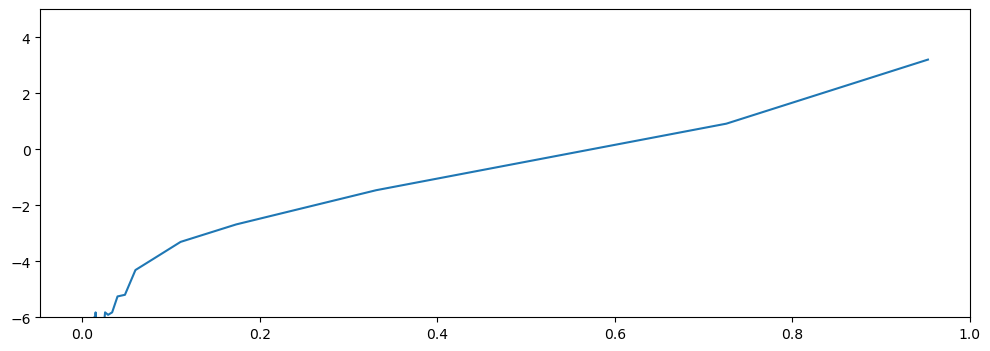

In [94]:
plt.figure(figsize=(12,4))
plt.ylim([-6,5])
plt.plot(cal_bins['score_raw'],cal_bins['log_odds'])
# plt.plot(cal_bins['score_raw'],cal_bins['log_odds_adj'])
# plt.xlim([0,1])

In [95]:
def funcg(x, a, b, c):
    return c + b/(1 + np.exp(-a * x))

def funcf(x, a, b, c):
    return -np.log(-1 + b/(x - c))/a

In [96]:
from scipy.optimize import curve_fit
popt, pcov = curve_fit(funcg, cal_bins['log_odds_adj'],cal_bins['score_raw'])   
print(popt)

[ 0.61739194  1.1147486  -0.00699567]


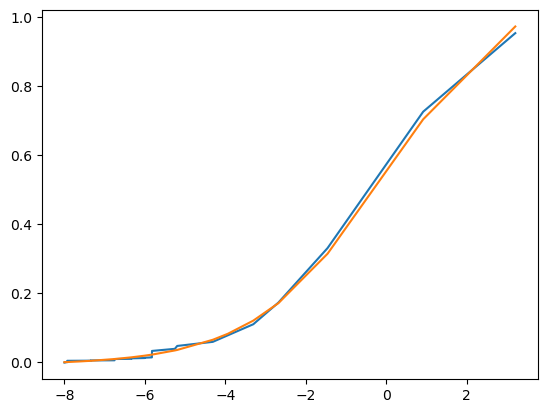

In [97]:
# plt.plot(cal_bins['log_odds'],cal_bins['score'])
plt.plot(cal_bins['log_odds_adj'],cal_bins['score_raw'])
plt.plot(cal_bins['log_odds_adj'],funcg(cal_bins['log_odds_adj'], *popt))

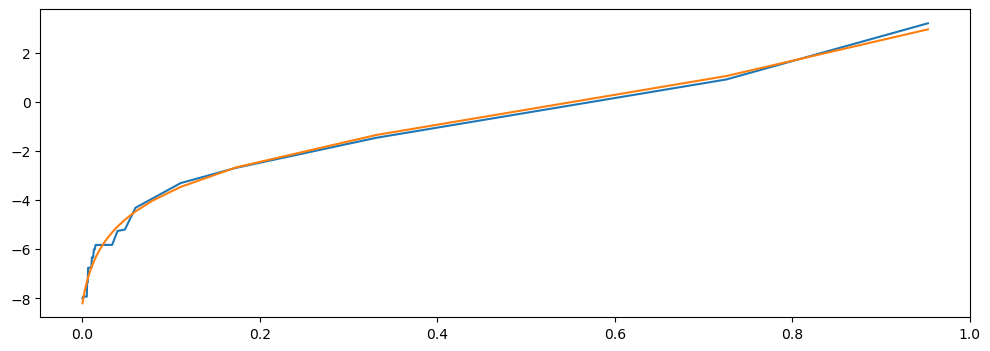

In [98]:
# look at the smooth curve fit to see if it's OK.
plt.figure(figsize=(12,4))
plt.plot(cal_bins['score_raw'], cal_bins['log_odds_adj'])
plt.plot(cal_bins['score_raw'], funcf(cal_bins['score_raw'], *popt))

In [99]:
# The fit looks pretty good
cal_bins['fit'] = funcf(cal_bins['score_raw'], *popt)
cal_bins.head(10)

,bin,#recs,#g,#b,%g,%b,tot,cg,cb,score_raw,prob(%),odds,log_odds,log_odds_adj,fit
1,1.0,980.0,980.0,0.0,100.000000,0.000000,980.0,980.0,0.0,0.000010,0.000000,0.000001,-19.902422,-8.0,-8.201209
2,2.0,981.0,981.0,0.0,100.000000,0.000000,1962.0,1961.0,0.0,0.000010,0.000000,0.000001,-19.903894,-8.0,-8.201177
3,3.0,980.0,979.0,1.0,99.897959,0.102041,2940.0,2940.0,1.0,0.000023,0.102041,0.001022,-9.933723,-8.0,-8.198231
4,4.0,980.0,980.0,0.0,100.000000,0.000000,3920.0,3920.0,1.0,0.000045,0.000000,0.000001,-19.902422,-8.0,-8.193044
5,5.0,981.0,981.0,0.0,100.000000,0.000000,4905.0,4901.0,1.0,0.000072,0.000000,0.000001,-19.903894,-8.0,-8.186868
6,6.0,980.0,980.0,0.0,100.000000,0.000000,5880.0,5881.0,1.0,0.000098,0.000000,0.000001,-19.902422,-8.0,-8.180797
7,7.0,981.0,981.0,0.0,100.000000,0.000000,6867.0,6862.0,1.0,0.000125,0.000000,0.000001,-19.903894,-8.0,-8.174572
8,8.0,980.0,980.0,0.0,100.000000,0.000000,7840.0,7842.0,1.0,0.000153,0.000000,0.000001,-19.902422,-8.0,-8.168298
9,9.0,980.0,980.0,0.0,100.000000,0.000000,8820.0,8822.0,1.0,0.000182,0.000000,0.000001,-19.902422,-8.0,-8.161575
10,10.0,981.0,981.0,0.0,100.000000,0.000000,9810.0,9803.0,1.0,0.000217,0.000000,0.000001,-19.903894,-8.0,-8.153840


In [100]:
# Here's the calibrated score
cal_bins['score_calib'] = base + delta * cal_bins['fit'] - delta * np.log2(odds_at_base)
cal_bins['score_calib'].fillna(999, inplace=True)
cal_bins['score_calib'].clip(upper=999, inplace=True)

/tmp/ipykernel_58160/1415719438.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  cal_bins['score_calib'].fillna(999, inplace=True)
/tmp/ipykernel_58160/1415719438.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', t

In [101]:
pd.set_option('display.max_rows', 100)
cal_bins.to_csv('cal_bins.csv')
cal_bins.tail(30)

,bin,#recs,#g,#b,%g,%b,tot,cg,cb,score_raw,prob(%),odds,log_odds,log_odds_adj,fit,score_calib
71,71.0,980.0,978.0,2.0,99.795918,0.204082,69580.0,69495.0,111.0,0.007556,0.204082,0.002046,-8.932969,-6.754727,-7.006129,526.315992
72,72.0,981.0,974.0,7.0,99.286442,0.713558,70632.0,70469.0,118.0,0.007919,0.713558,0.007188,-7.120217,-6.754727,-6.965720,527.124158
73,73.0,980.0,975.0,5.0,99.489796,0.510204,71540.0,71444.0,123.0,0.008250,0.510204,0.005129,-7.607042,-6.754727,-6.929668,527.845200
74,74.0,980.0,974.0,6.0,99.387755,0.612245,72520.0,72418.0,129.0,0.008621,0.612245,0.006161,-7.342575,-6.754727,-6.890176,528.635033
75,75.0,981.0,977.0,4.0,99.592253,0.407747,73575.0,73395.0,133.0,0.009018,0.407747,0.004095,-7.931854,-6.754727,-6.848971,529.459152
76,76.0,980.0,975.0,5.0,99.489796,0.510204,74480.0,74370.0,138.0,0.009465,0.510204,0.005129,-7.607042,-6.754727,-6.803641,530.365734
77,77.0,980.0,973.0,7.0,99.285714,0.714286,75460.0,75343.0,145.0,0.009989,0.714286,0.007195,-7.118735,-6.754727,-6.752174,531.395084
78,78.0,981.0,969.0,12.0,98.776758,1.223242,76518.0,76312.0,157.0,0.010575,1.223242,0.012385,-6.335270,-6.335270,-6.696328,532.512003
79,79.0,980.0,971.0,9.0,99.081633,0.918367,77420.0,77283.0,166.0,0.011237,0.918367,0.009270,-6.753242,-6.335270,-6.635493,533.728705
80,80.0,981.0,969.0,12.0,98.776758,1.223242,78480.0,78252.0,178.0,0.011979,1.223242,0.012385,-6.335270,-6.335270,-6.569761,535.043341


In [102]:
calib.head()

,score_raw,Fraud
26418,0.00001,0.0
26457,0.00001,0.0
22480,0.00001,0.0
26289,0.00001,0.0
40357,0.00001,0.0


In [103]:
calib['score_calib'] = base - delta * np.log2(odds_at_base) + delta * funcg(calib['score_raw'], *popt)
calib['score_calib'].fillna(999, inplace=True)
calib['score_calib'].clip(upper=999, inplace=True)
calib.head()

/tmp/ipykernel_58160/2868135245.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  calib['score_calib'].fillna(999, inplace=True)
/tmp/ipykernel_58160/2868135245.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try 

,score_raw,Fraud,score_calib
26418,0.00001,0.0,677.446169
26457,0.00001,0.0,677.446169
22480,0.00001,0.0,677.446169
26289,0.00001,0.0,677.446169
40357,0.00001,0.0,677.446169


In [104]:
calib.tail()

,score_raw,Fraud,score_calib
81587,0.999,1.0,680.77889
81657,0.999,1.0,680.77889
81592,0.999,1.0,680.77889
81612,0.999,1.0,680.77889
81648,0.999,1.0,680.77889


In [105]:
calib.describe()

,score_raw,Fraud,score_calib
count,98037.000000,98037.000000,98037.000000
mean,0.029939,0.025419,677.547742
std,0.124135,0.157395,0.417501
min,0.000010,0.000000,677.446169
25%,0.000936,0.000000,677.449354
50%,0.003246,0.000000,677.457305
75%,0.009236,0.000000,677.477919
max,0.999000,1.000000,680.778890


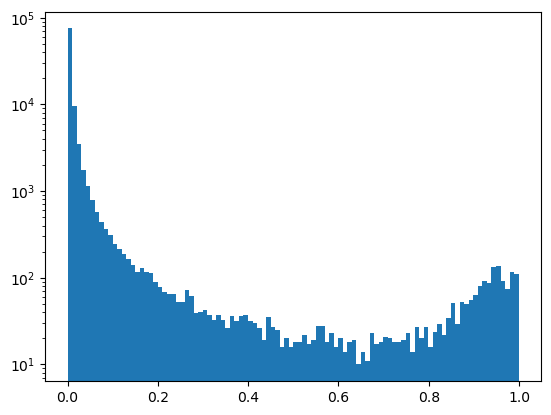

In [106]:
nbins=100
plt.hist(calib['score_raw'],bins=nbins)
plt.yscale('log')

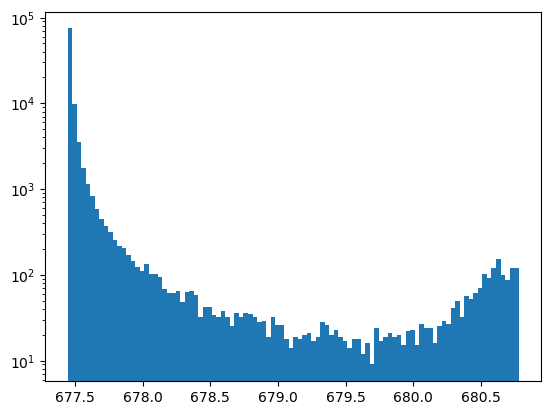

In [107]:
plt.hist(calib['score_calib'],bins=nbins)
plt.yscale('log')

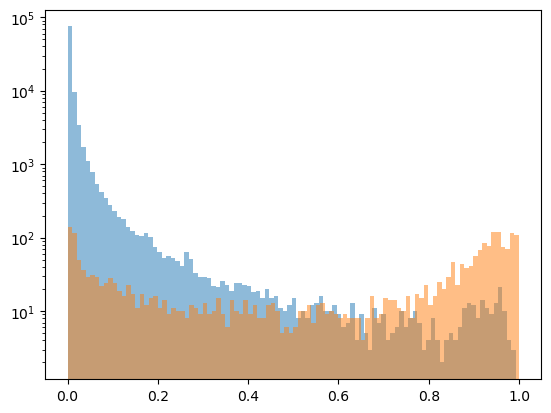

In [108]:
goods = calib[calib['Fraud']==0]
bads = calib[calib['Fraud']==1]
plt.hist(goods['score_raw'],bins = nbins, alpha = .5)
plt.hist(bads['score_raw'],bins = nbins, alpha = .5)
plt.yscale('log')

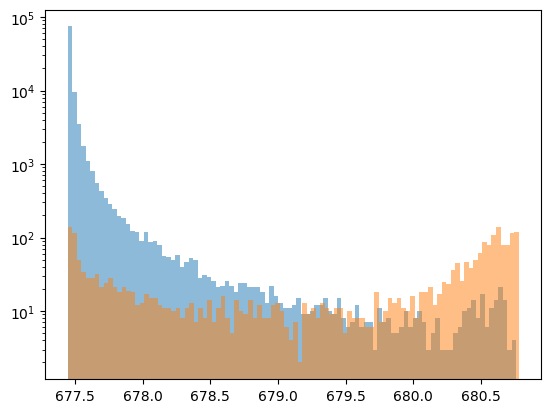

In [109]:
plt.hist(goods['score_calib'],bins = nbins, alpha = .5)
plt.hist(bads['score_calib'],bins = nbins, alpha = .5)
plt.yscale('log')

In [110]:
import scipy.stats as sps
KS = sps.ks_2samp(goods['score_raw'],bads['score_raw'])[0]
print(KS)

0.8013300229896798


In [111]:
print("duration: ", datetime.now() - start_time)

duration:  0:14:06.547567


In [112]:
%pwd

'/mnt/c/Users/nitya/OneDrive/Desktop/nvrsm/fraud analytics'